---
title: Titanic - Machine Learning from Disaster
subtitle: Final project submission for course 246502301 - Data Science Lab 1 at Afeka College of engineering
authors:
  - name: Michael Berger
    email: michael.berger.e@gmail.com
  - name: Son Levi
    email: sonxoxo@gmail.com
date: 2024/05/15
exports:
  - format: docx
    template: curvenote
    output: titanic.docx
  - format: pdf
    template: arxiv_nips
    output: titanic.pdf
  - format: pdf
    template: lapreprint
    line_spacing: onehalfspacing
    number_sections: true
    output: titanic_lapreprint.pdf
#  - format: pdf
#    template: curvenote
---

In [215]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
pref = ''

# if running on local
if os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')=='':
    pref = ''
# if running on kaggle
elif os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')=='Interactive':
    pref = '/kaggle/input/titanic/'
# if running on colab
else:        
    import sys
    from tempfile import NamedTemporaryFile
    from urllib.request import urlopen
    from urllib.parse import unquote, urlparse
    from urllib.error import HTTPError
    from zipfile import ZipFile
    import tarfile
    import shutil
    
    CHUNK_SIZE = 40960
    DATA_SOURCE_MAPPING = 'titanic:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F3136%2F26502%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240427%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240427T185713Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D7d5e8fb644f88bb3c1216b99279e5d7b03fdf539c154d3b1bb63bca36941876c5943680cad6834046d3aca8bdf90a32f25d8e90abf44ecdee97f198dca66f58cea19558f6047bd39c10d52b5b8a0d129860f50f1dbf01be349f354894b0fa1b990c5eefe13c64bb89736e535fb4b576a52a03b3c54e52600602e32e99c06046817e9033b88d243372ce7d73d5bcdc3959a95ac635f0605b7fd819bdc32abca86457c5134bfa03b9d8c19d85cdf95d55ad23dfea13c6c3a7cd1698b3c974e8d974190771ce8e7361b7ff82362c2c5531ab1872df3feb7a8c4e698103240f3435816898262816d665ddd64fc05c4692c9a3e87eadaf8250dadd42c2e9fc8eb1d5b'
    
    KAGGLE_INPUT_PATH='/kaggle/input'
    KAGGLE_WORKING_PATH='/kaggle/working'
    KAGGLE_SYMLINK='kaggle'
    
    !umount /kaggle/input/ 2> /dev/null
    shutil.rmtree('/kaggle/input', ignore_errors=True)
    os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
    os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)
    
    try:
      os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
    except FileExistsError:
      pass
    try:
      os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
    except FileExistsError:
      pass
    
    for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
        directory, download_url_encoded = data_source_mapping.split(':')
        download_url = unquote(download_url_encoded)
        filename = urlparse(download_url).path
        destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
        try:
            with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
                total_length = fileres.headers['content-length']
                print(f'Downloading {directory}, {total_length} bytes compressed')
                dl = 0
                data = fileres.read(CHUNK_SIZE)
                while len(data) > 0:
                    dl += len(data)
                    tfile.write(data)
                    done = int(50 * dl / int(total_length))
                    sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                    sys.stdout.flush()
                    data = fileres.read(CHUNK_SIZE)
                if filename.endswith('.zip'):
                  with ZipFile(tfile) as zfile:
                    zfile.extractall(destination_path)
                else:
                  with tarfile.open(tfile.name) as tarfile:
                    tarfile.extractall(destination_path)
                print(f'\nDownloaded and uncompressed: {directory}')
        except HTTPError as e:
            print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
            continue
        except OSError as e:
            print(f'Failed to load {download_url} to path {destination_path}')
            continue
    
    print('Data source import complete.')


In [3]:
#!conda install -y matplotlib numpy  seaborn  plotly scikit-learn  pandasql  scipy

In [212]:
#!pip install kaleido

# Overview

The data has been split into two groups:

- training set (train.csv)
- test set (test.csv)

The training set should be used to build your machine learning models. For the training set, we provide the outcome (also known as the “ground truth”) for each passenger. Your model will be based on “features” like passengers’ gender and class. You can also use feature engineering to create new features.

The test set should be used to see how well your model performs on unseen data. For the test set, we do not provide the ground truth for each passenger. It is your job to predict these outcomes. For each passenger in the test set, use the model you trained to predict whether or not they survived the sinking of the Titanic.

We also include gender_submission.csv, a set of predictions that assume all and only female passengers survive, as an example of what a submission file should look like.

**Data Dictionary**

|Variable|	Definition|	Key|
|----:|:------------:|:------|
|survival|	Survival|	0 = No, 1 = Yes|
|pclass|	Ticket class|	1 = 1st, 2 = 2nd, 3 = 3rd|
|sex|	Sex	|
|Age|	Age in years	|
|sibsp|	# of siblings / spouses aboard the Titanic|
|parch|	# of parents / children aboard the Titanic|
|ticket|	Ticket number	| |
|fare|	Passenger fare	| |
|cabin|	Cabin number	| |
|embarked|	Port of Embarkation|	C = Cherbourg, Q = Queenstown, S = Southampton|

**Variable Notes**

**pclass**: A proxy for socio-economic status (SES)
1st = Upper
2nd = Middle
3rd = Lower

**age**: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

**sibsp**: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

**parch**: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

```{note} 
**This submission was made with MyST**  
MyST (Markedly Structured Text) is designed to create publication-quality documents
written entirely in Markdown. The markup and publishing build system is fantastic,
MyST seamlessly exports to any PDF template, while collecting metadata to make your
writing process as easy as possible.
```

**We split the work so Michael will be mainly responsible for the data cleansing and Preprocessing and Son will be mainly responsible for the model training and Evaluating. We both show our individual Data Exploration and merge if necessary.**

# Libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import plotly.express as px
import plotly.subplots as subplots
from plotly.subplots import make_subplots
import plotly.io as pio
import plotly.graph_objects as go

# sklearn imports
from sklearn import metrics
from sklearn import pipeline
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection

from sklearn.model_selection import ( train_test_split, cross_val_predict,
                                        GridSearchCV, cross_val_score)
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import (GradientBoostingClassifier, RandomForestClassifier,
                                RandomForestRegressor, AdaBoostRegressor, 
                                GradientBoostingRegressor)
from sklearn.metrics import (accuracy_score, confusion_matrix, precision_score, 
                            recall_score, f1_score)
from sklearn.tree import DecisionTreeClassifier

import pandasql as ps

import os
from datetime import datetime
import json
import scipy.stats as st

## Project definitions, configurations and hacks

In [6]:


%matplotlib inline

#define default layout for plotly plots
pio.templates["LabReport"] = go.layout.Template(
             layout=dict(font={"size": 18},
                            yaxis= {"automargin": True},
                            margin=dict(l=10, r=10, b=10),
                            autosize= True
                           )
)


# pio.templates["LabReport"] =go.layout.Template(
#     layout=dict(font={"size": 20},
#                 yaxis= {"automargin": True},
#                 #minreducedwidth=250,
#                 #minreducedheight=20,
#                 margin=dict(t=60, l=10, r=10, b=10),
#                 autosize= False,  height = 400,
#                 # title={"yref": "paper", "y" : .99,
#                 #        "yanchor" : "top"} 
#            ))



# pio.templates["LabReport"] = go.layout.Template(
#              layout=dict(font={"size": 20},
#                             margin=dict(t=10, l=10, r=10, b=10),
#                             autosize= True,  height = 800,
#                             title={"yref": "paper", "y" : 1,
#                                    "yanchor" : "top"}   )
# )


# width = 1000,
# Then combine your modification with any of the 
# available themes like this:
pio.templates.default = "plotly_white+LabReport"

#pio.renderers.default = "notebook+pdf"
#pio.renderers.default = "sphinx_gallery"
pio.renderers.default = "plotly_mimetype+jpeg"


# limit on iterations for Cross-Validation.
# while authoring the document, I don't want tot re-run long CV each time I test.
# set it to high (~1000) for the release build
iterations=10

#TODO: automate
#if running on kaggle
#pref = '/kaggle/input/titanic/'
# if running on local
#pref = ''

def format(obj):
    #print(type(obj))
    if type(obj)==dict:
        conv = str(obj)
        return conv
    if type(obj)==float:
        return '{:.2f}'.format(obj)
    else:
        return str(obj)


def lstr(obj):
    return min(len(str(obj)),20)

def coldim(col):
    import math
    m = 20
    def lal(obj):
        l = len(str(obj))
        #return {"wid": min(l,m), "hei": math.ceil(l/m)}
        return [min(l,m), math.ceil(l/m)]
    #print(col.name)
    #print(col)
    col = col.map(format).astype(str)
    
    wat = col.apply(lambda row: lal(row))
    wat
    
    wat = pd.DataFrame(np.vstack(wat.values), columns=['wid','hei'])
    #print(col.name)
    #print(wat)
    
    return [wat.wid.max(), wat.hei.sum()+1]

## render df output as plotly table - for PDF conversion
def render_df(df):
    headerColor = 'grey'
    rowEvenColor = 'lightgrey'
    rowOddColor = 'white'

    df = df.map(format)
    #print(df.dtypes)
    #TODO: calculate height of resulting table - for figure height determination 
    hWidths = [len(c) for c in df.columns]

    cDims = [coldim(df[c]) for c in df]
    wh = pd.DataFrame(cDims, columns=["w","h"])
    cWidths = wh.w
    tHeight = wh.h.max()
    #print(cWidths, tHeight)
    cWidths = [max(h,c) for h,c in zip(hWidths, cWidths)]
    
    tbl = go.Table(
      columnwidth = cWidths,
      header=dict(
        values=list(df.columns),
        line_color='darkslategray',
        fill_color=headerColor,
        align='center',
        font=dict(color='white', size=11)
      ),
      cells=dict(
        values=df.transpose().values.tolist(),
        line_color='darkslategray',
        # 2-D list of colors for alternating rows
        #fill_color = [[rowOddColor,rowEvenColor,rowOddColor, rowEvenColor,rowOddColor]*5],
        align = 'center',
        font = dict(color = 'darkslategray', size = 13)
        ))
    layout=dict(margin=dict(t=10, b=10, l=10, r=10),
                            height=tHeight*20 + 30 + 10 + 10,
                               autosize= True)   
    
    fig = go.Figure(data=[tbl], layout=layout)
    #fig.update_layout(autosize= True)
    return fig


# a little quick, dirty and hacky trick. Don't ever do this.
# Inject a function vu into pandas.DataFrame class.
# vu defines the style for displaying the df in output
def vu(self, n=10, r= True, i=False):    
    if r:
        df = self.sample(n, random_state=42)# .style.format(precision=2).hide(axis="index")
    else:
        df = self.head(n)
    if i:
        df.insert( loc=0, column=df.index.name, value=df.index)
    
    return render_df(df)

pd.DataFrame.vu = vu

pd.set_option('display.precision', 2)

pref = "/kaggle/input/titanic/"

# Reading Train Data

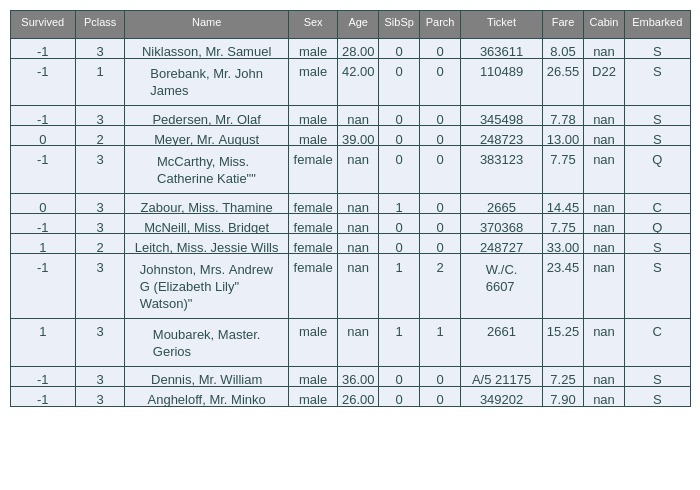

In [7]:
passenger_df_train = pd.read_csv(pref+"train.csv", index_col="PassengerId")
passenger_df_test = pd.read_csv(pref+"test.csv", index_col="PassengerId")

passenger_df_test["Survived"] = -1
passenger_df = pd.concat([passenger_df_train, passenger_df_test])

passenger_df.vu(12)

**Which features are categorical?**

These values classify the samples into sets of similar samples. Within categorical features are the values nominal, ordinal, ratio, or interval based? Among other things this helps us select the appropriate plots for visualization.

- Categorical: Survived, Sex, and Embarked. Ordinal: Pclass.

**Which features are numerical?**

Which features are numerical? These values change from sample to sample. Within numerical features are the values discrete, continuous, or timeseries based? Among other things this helps us select the appropriate plots for visualization.

- Continous: Age, Fare. Discrete: SibSp, Parch.

**Which features may contain errors or typos?**

- Name feature may contain errors or typos as there are several ways used to describe a name including titles, round brackets, and quotes used for alternative or short names.

# Explatory Data Analysis (EDA) and Data Visualization

## Part 1 - Data Visualization

### Describe Data

**Check if there any null values**

In [8]:
def summary(df):
    nonnans = df.shape[0] - df.isna().sum()
    nonnansPrc = (nonnans / df.shape[0] * 100).apply("{0:.2f}%".format)
    sam = df.sample(1, random_state=42).squeeze()
    res = pd.DataFrame([sam.index, df.dtypes.astype(str), nonnans,
                        nonnansPrc, df.nunique(), sam]).transpose()
    res.columns = ["Column", "data type", "non-null values", 
                   "non-null values %", "unique values", "example"]
    res.sort_values("unique values",ascending=False, inplace=True)
    return res

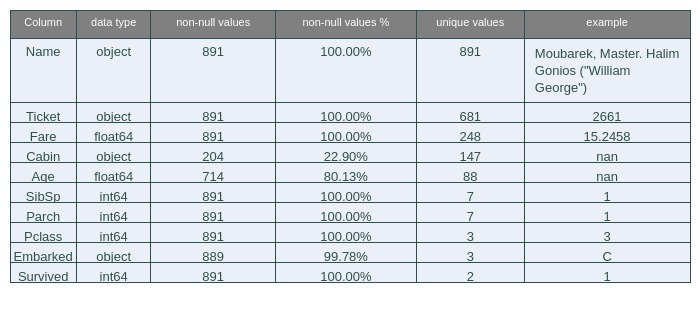

In [9]:
summary(passenger_df_train).vu(r=0)

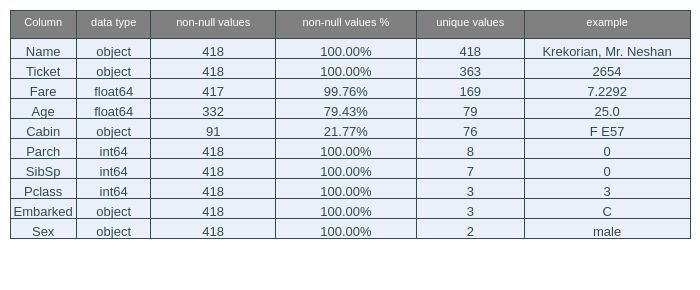

In [10]:
summary(passenger_df_test).vu(r=0)

In [11]:
passenger_df_train.describe()

Survived  Pclass     Age   SibSp   Parch    Fare
count    891.00  891.00  714.00  891.00  891.00  891.00
mean       0.38    2.31   29.70    0.52    0.38   32.20
std        0.49    0.84   14.53    1.10    0.81   49.69
min        0.00    1.00    0.42    0.00    0.00    0.00
25%        0.00    2.00   20.12    0.00    0.00    7.91
50%        0.00    3.00   28.00    0.00    0.00   14.45
75%        1.00    3.00   38.00    1.00    0.00   31.00
max        1.00    3.00   80.00    8.00    6.00  512.33

**Which features contain blank, null or empty values?**

These will require correcting.

- Cabin > Age > Embarked features contain a number of null values in that order for the training dataset.
- Cabin > Age are incomplete in case of test dataset.

**What are the data types for various features?**

Helping us during converting goal.

- Seven features are integer or floats. Six in case of test dataset.
- Five features are strings (object).

### Amount of Survivors

In [12]:

def create_pie_chart_of_count(df, column_name):
    df_not_null = df[~df[column_name].isnull()]
    fig = px.pie(df_not_null.groupby([column_name]).size().reset_index(name='count'), 
                 names=column_name, values='count')
    return fig

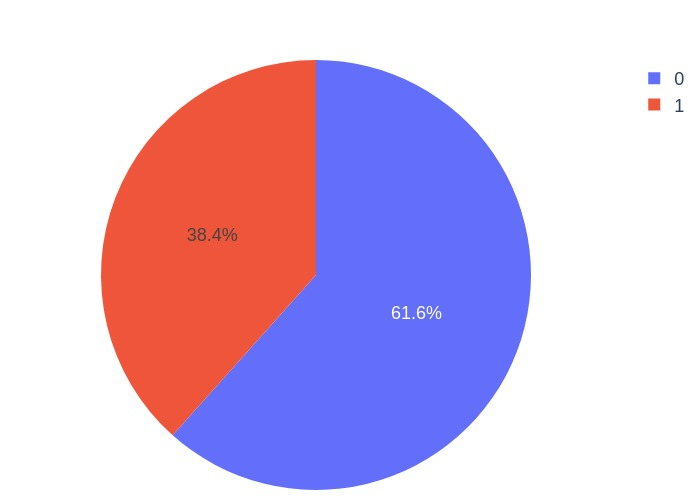

In [13]:
create_pie_chart_of_count(passenger_df_train, 'Survived')

### Pie Charts for Embark, Sex and Pclass

In [14]:
def create_pie_chart_subplot_of_count(df, columns_names):
    rows = int(np.ceil(np.sqrt(len(columns_names))))
    cols = int(np.ceil(len(columns_names)/rows))
    fig = make_subplots(rows=rows, cols=cols, specs=[[{"type": "domain"} for i in range(cols)] for j in range(rows)])
    for i, column_name in enumerate(columns_names):
        df_not_null = df[~df[column_name].isnull()]
        fig.add_trace(go.Pie(labels=df_not_null.groupby([column_name]).size().reset_index(name='count')[column_name],
                             values=df_not_null.groupby([column_name]).size().reset_index(name='count')['count'],
                             name=column_name),
                      (i)//cols+1, (i)%cols+1)
    fig.update_layout(margin=dict(t=10, l=10, r=10, b=10))
    return fig

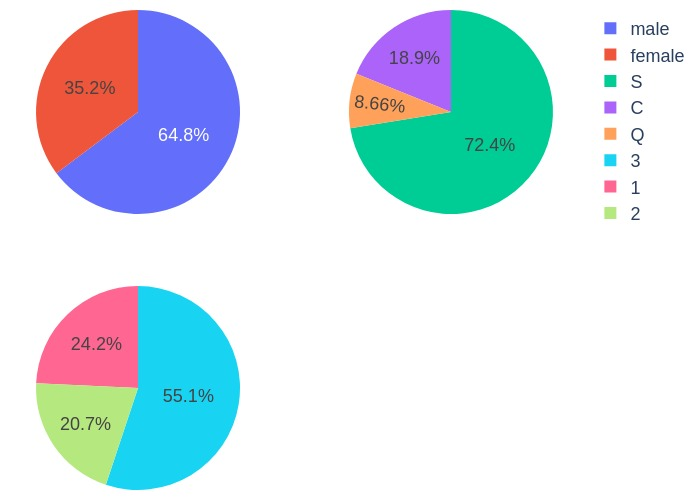

In [15]:
create_pie_chart_subplot_of_count(passenger_df_train, ['Sex', 'Embarked', 'Pclass'])


### Histograms for Siblings/Spouse and Parents/Children

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



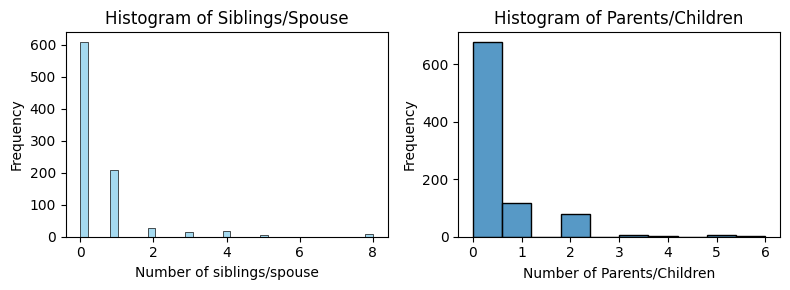

In [16]:
# Create figure and axes objects
fig, axs = plt.subplots(1, 2, figsize=(8,3))

# Plot histograms for 'SibSp', 'Parch', and 'Age'
sns.histplot(passenger_df_train['SibSp'], ax=axs[0], color='skyblue', edgecolor='black', kde=False)
axs[0].set_title('Histogram of Siblings/Spouse')
axs[0].set_xlabel('Number of siblings/spouse')
axs[0].set_ylabel('Frequency')

sns.histplot(passenger_df_train['Parch'], ax=axs[1], edgecolor='black', bins=10, kde=False)
axs[1].set_title('Histogram of Parents/Children')
axs[1].set_xlabel('Number of Parents/Children')
axs[1].set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot

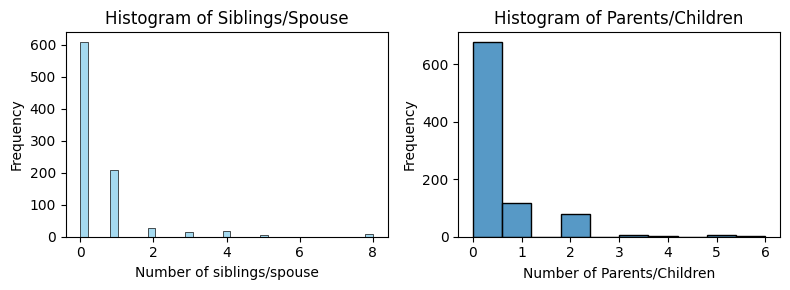

In [17]:
fig

## Observations in a Nutshell for all features separately:

**passengers**:
1. There were 891 passengers in the data, with 681 unique tickets and 148 Cabins
2. Most passengers did not stay at a Cabin.

**sex**:
1. 65% of passengers are male and the rest female

**survived**:
1. 38% of passengers survived the disaster

**embarked**:
1. The majority of the passengers embarked from Southampton (makes sense because assumed higher population)
2. small amount of passengers have an unknown embarkment

**pclass**:
1. Most of the passengers are 3rd Class

**age**:
1. There are 177 passengers that have an unknown age
2. The average age is 23 and most of the passengers were in their 20's

**sibsp**:
1. 600+ passengers were without siblings/spouses
2. 1 Outlier of 8 siblings/spouse (probably the family members as each index)

**parch**:
1. The big majority of the passengers are without parents/children
2. No big outlier (max=6)
3. Mainly between 0-2

## Assumptions based on the data

**<u>Correlating</u>**

We want to know how well does each feature correlate with Survival.

**<u>Completing</u>**

1. We may want to complete Age feature as it is definitely correlated to survival.
2. We may want to complete the Embarked feature as it may also correlate with survival or another important feature.

**<u>Filtering</u>**

1. Ticket feature may be dropped from our analysis as it contains high ratio of duplicates (22%) and there may not be a correlation between Ticket and survival.
2. Cabin feature may be dropped as it is highly incomplete or contains many null values both in training and test dataset.
3. PassengerId may be dropped from training dataset as it does not contribute to survival.
4. Name feature is relatively non-standard, may not contribute directly to survival, so maybe dropped.

**<u>Engineering</u>**

1. We may want to create a new feature called Family based on Parch and SibSp to get total count of family members on board.
2. We may want to engineer the Name feature to extract Title as a new feature.
3. We may want to create new feature for Age bands. This turns a continous numerical feature into an ordinal categorical feature.
4. We may also want to create a Fare range feature if it helps our analysis.
5. We may want to divide the Cabin into Letter and number of cabin instead of filtering the feature completely to get further information.

**<u>Classifying</u>**

We may also add to our assumptions based on the problem description noted earlier.

1. Women (Sex=female) were more likely to have survived.
2. Children (Age<?) were more likely to have survived.
3. The upper-class passengers (Pclass=1) were more likely to have survived.

## Data Exploration

To confirm some of our observations and assumptions, we can quickly analyze our feature correlations by pivoting features against each other. We can only do so at this stage for features which don't have empty values. It also makes sense doing so only for feature types which are categorical (Sex), ordinal (Pclass) or discrete (SibSp, Parch).

- **Pclass** We observe significant correlation (>0.5) among Pclass=1 and Survived (classifying #3). We decide to include this feature in our model.
- **Sex** We confirm the observation during problem definition that Sex=female had very high survival rate at 74% (classifying #1).
- **SibSp and Parch** These features have zero correlation for certain values. It may be best to derive a feature or a set of features from these individual features (engineering #1).

### Comparing non-null features to survived

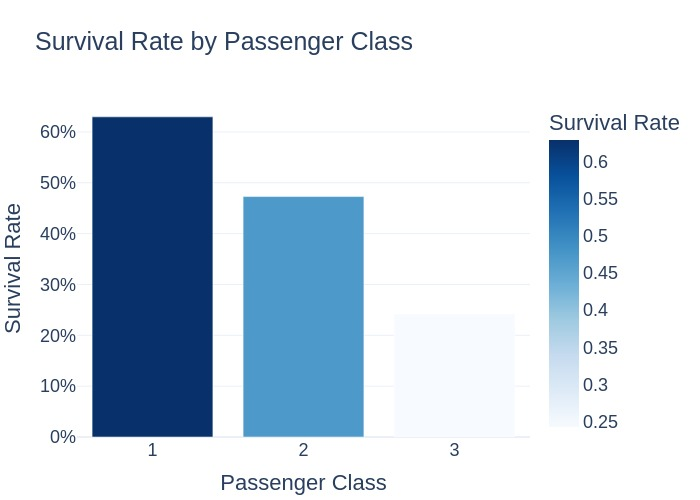

In [18]:
# Your DataFrame and calculation
data = passenger_df_train[['Pclass', 'Survived']].groupby(['Pclass'],
    as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Pclass', y='Survived', title='Survival Rate by Passenger Class',
             labels={'Pclass': 'Passenger Class', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='blues')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat=',.0%')

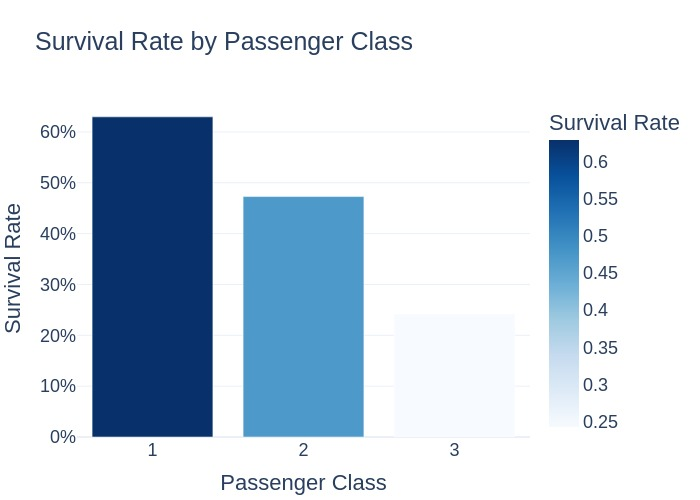

In [19]:
display(fig)

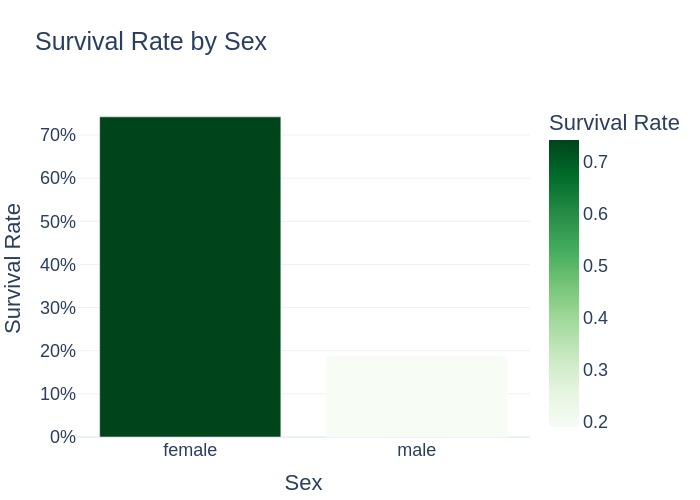

In [20]:
# Your DataFrame and calculation
data = passenger_df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Sex', y='Survived', title='Survival Rate by Sex',
             labels={'Sex': 'Sex', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='greens')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat=',.0%')

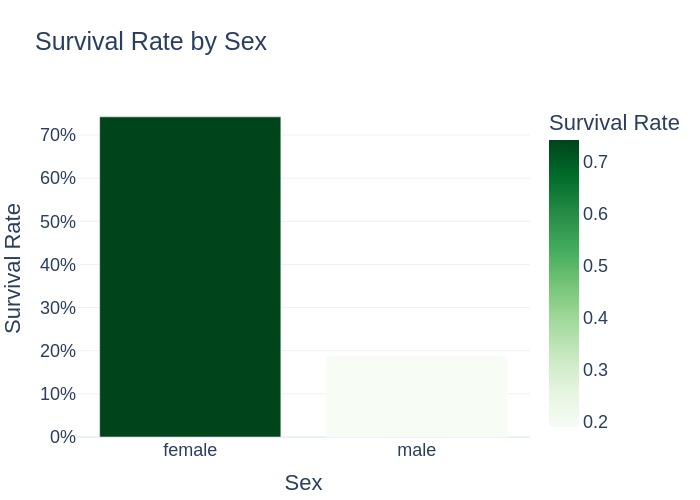

In [21]:
fig

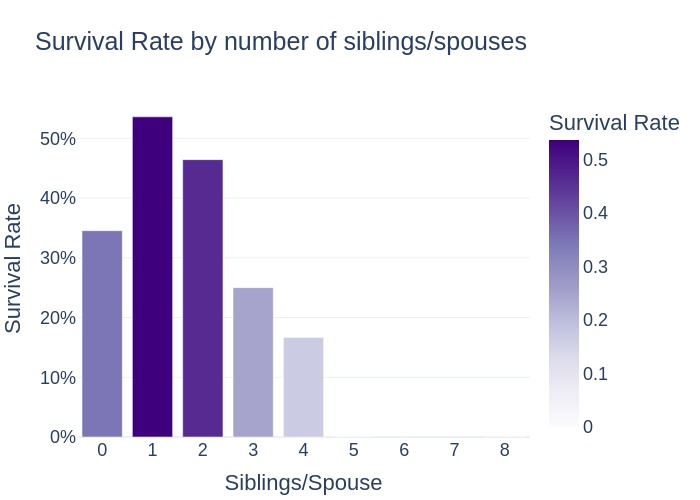

In [22]:
# Your DataFrame and calculation
data = passenger_df_train[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='SibSp', y='Survived', title='Survival Rate by number of siblings/spouses',
             labels={'SibSp': 'Siblings/Spouse', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='purples')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat=',.0%')

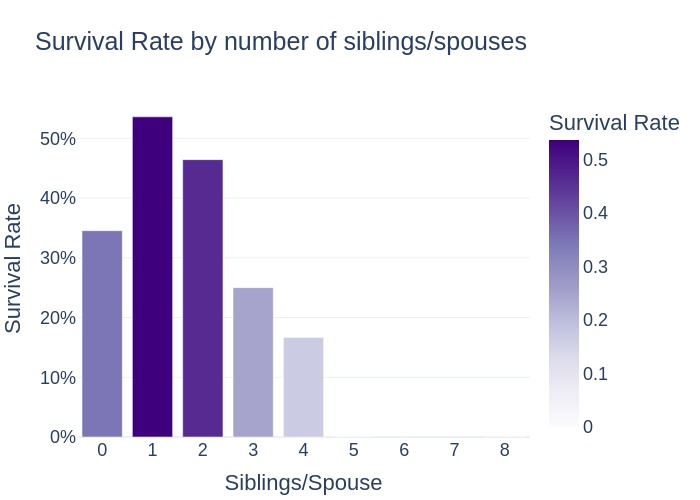

In [23]:
fig

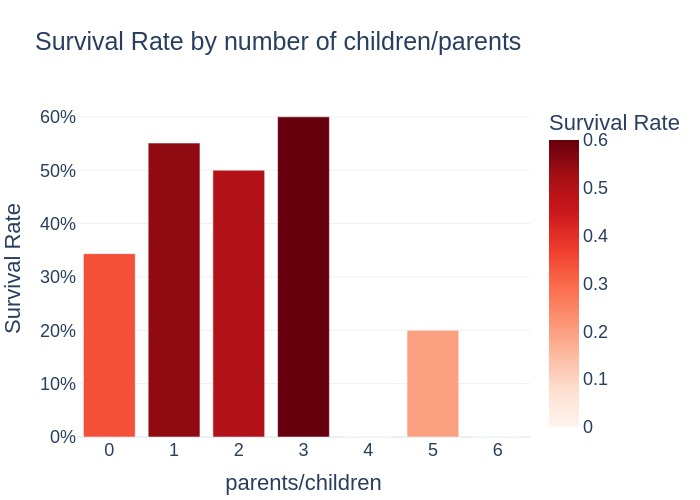

In [24]:
# Your DataFrame and calculation
data = passenger_df_train[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Parch', y='Survived', title='Survival Rate by number of children/parents',
             labels={'Parch': 'parents/children', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='reds')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat=',.0%')

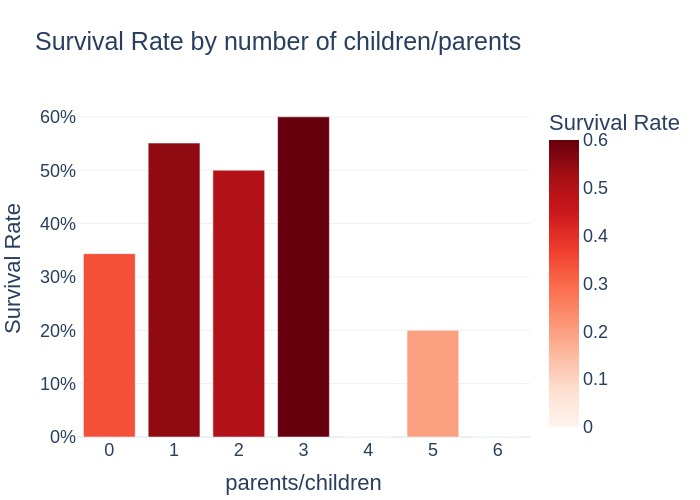

In [25]:
fig

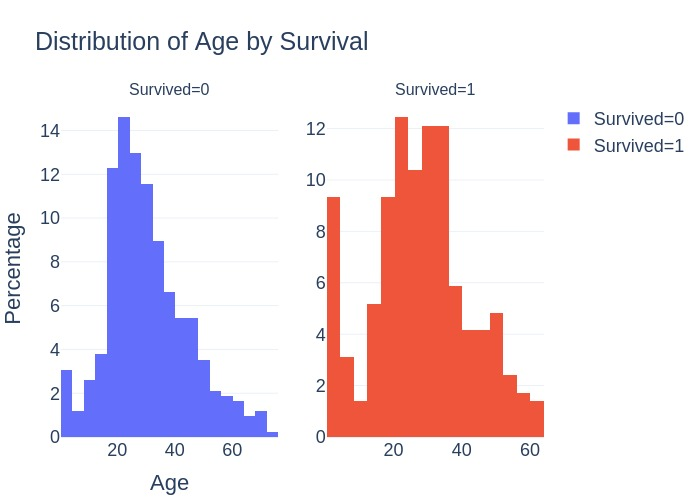

In [26]:
# Define bins for the histogram
bins = np.linspace(passenger_df_train['Age'].min(), passenger_df_train['Age'].max(), 20)

# Create subplots
fig = subplots.make_subplots(rows=1, cols=2, subplot_titles=("Survived=0", "Survived=1"))

# Create histograms for each subplot
for survived_val in [0, 1]:
    age_data = passenger_df_train[passenger_df_train['Survived'] == survived_val]['Age']
    histogram = go.Histogram(x=age_data, histnorm='percent', 
                             name=f'Survived={survived_val}', 
                             xbins=dict(start=min(bins), end=max(bins), 
                                        size=(max(bins)-min(bins))/len(bins)))
    fig.add_trace(histogram, row=1, col=survived_val + 1)

# Update layout
fig.update_layout(title_text="Distribution of Age by Survival",
                  xaxis_title="Age",
                  yaxis_title="Percentage",
                  showlegend=True)

### Based on the Age vs Survived Histograms:

**<u>Observations</u>**

- Infants (Age <=4) had high survival rate.
- Large number of 15-25 year olds did not survive.
- Most passengers are in 15-35 age range.

**<u>Decisions</u>**

- We should consider Age (classifying #2) in our model training.
- Complete the Age feature for null values (completing #1).
- We should band age groups (engineering #3).

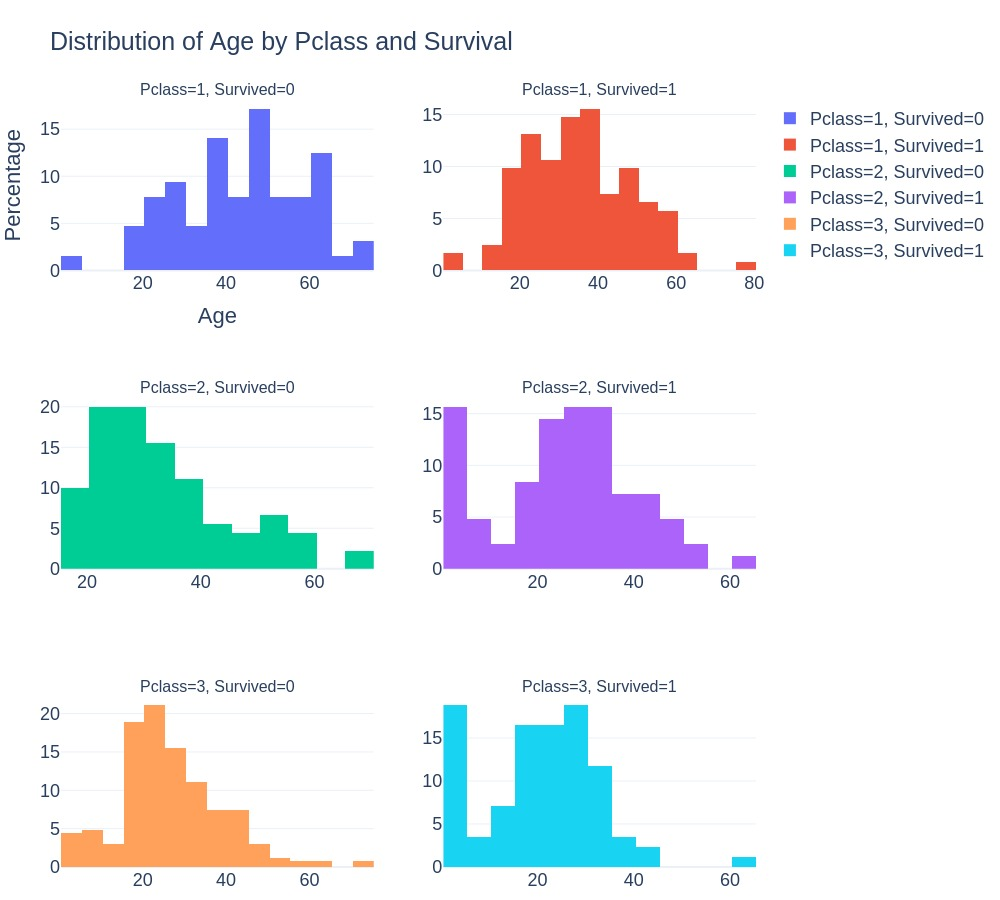

In [27]:
# Create subplots
fig = subplots.make_subplots(rows=3, cols=2, subplot_titles=("Pclass=1, Survived=0", "Pclass=1, Survived=1",
                                                            "Pclass=2, Survived=0", "Pclass=2, Survived=1",
                                                            "Pclass=3, Survived=0", "Pclass=3, Survived=1"))

# Create histograms for each subplot
for pclass_val in [1, 2, 3]:
    for survived_val in [0, 1]:
        age_data = passenger_df_train[(passenger_df_train['Pclass'] == pclass_val) & (passenger_df_train['Survived'] == survived_val)]['Age']
        histogram = go.Histogram(x=age_data, histnorm='percent', name=f'Pclass={pclass_val}, Survived={survived_val}', xbins=dict(start=passenger_df_train['Age'].min(), end=passenger_df_train['Age'].max(), size=5))
        fig.add_trace(histogram, row=pclass_val, col=survived_val + 1)

# Update layout
fig.update_layout(title_text="Distribution of Age by Pclass and Survival",
                  xaxis_title="Age",
                  yaxis_title="Percentage",
                  height=900, width=1000)

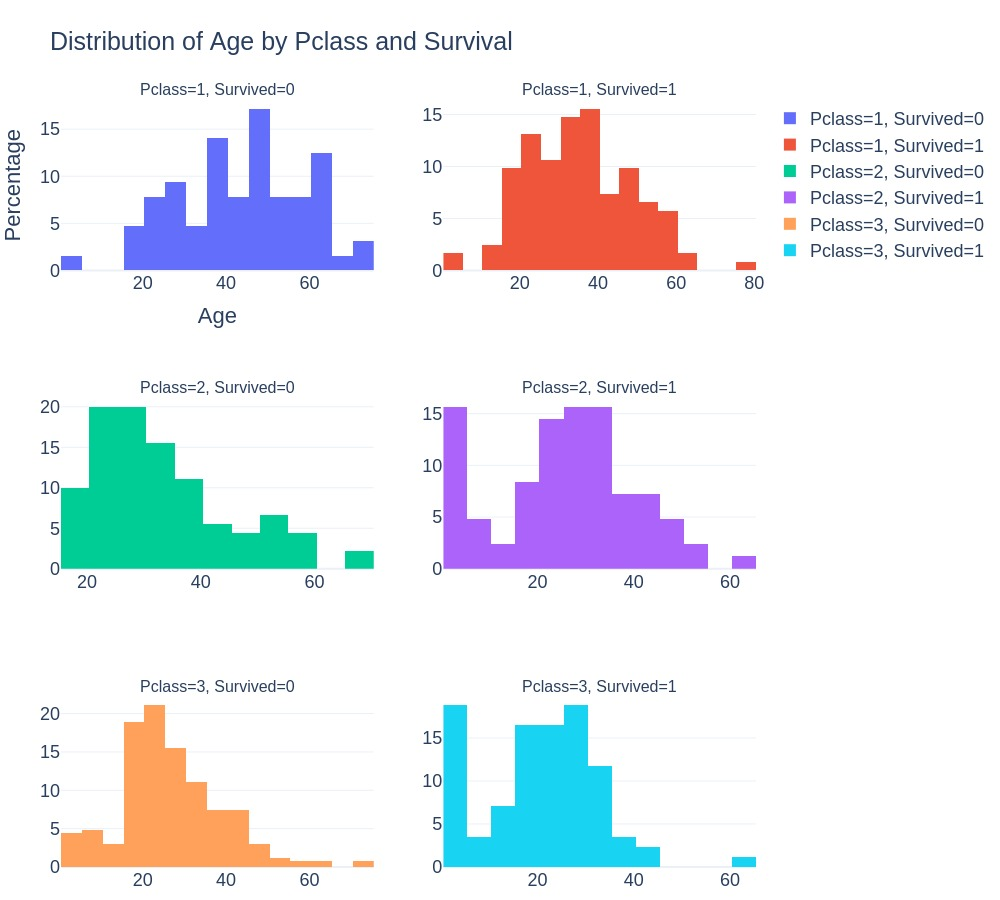

In [28]:
fig

### Based on the Pclass vs Survived Histograms:

**<u>Observations</u>**

- Pclass=3 had most passengers, however most did not survive. Confirms our classifying assumption #2.
- Oldest passengers (Age = 80) survived.
- Infant passengers in Pclass=2 and Pclass=3 mostly survived. Further qualifies our classifying assumption #2.
- Most passengers in Pclass=1 survived. Confirms our classifying assumption #3.
- Pclass varies in terms of Age distribution of passengers.

**<u>Decisions</u>**

- Consider Pclass for model training.

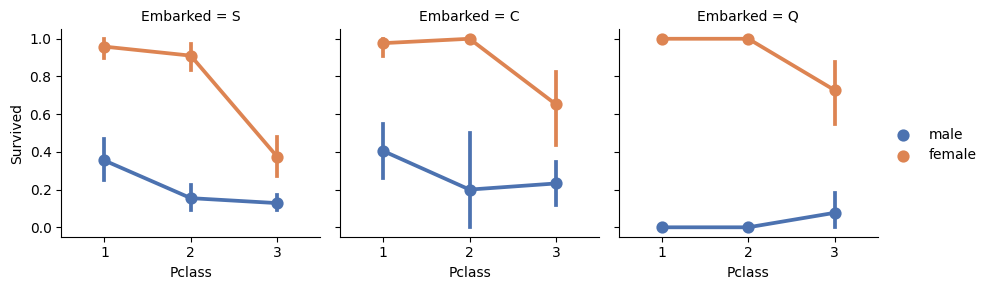

In [29]:
grid = sns.FacetGrid(passenger_df_train, col='Embarked')
grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette='deep', order=[1, 2, 3], hue_order=['male', 'female'])
grid.add_legend()

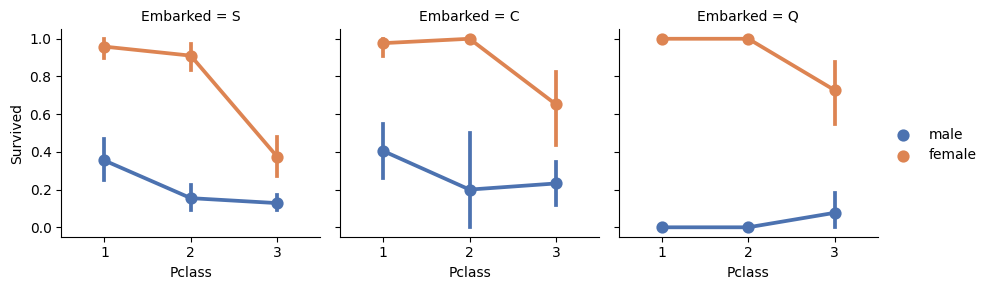

In [30]:
grid.fig

### Based on the Pclass vs Survived vs Sex based on Embarked pointplots:

**<u>Observations</u>**

- Female passengers had much better survival rate than males. Confirms classifying (#1).
- Exception in Embarked=C where males had higher survival rate. This could be a correlation between Pclass and Embarked and in turn Pclass and Survived, not necessarily direct correlation between Embarked and Survived.
- Males had better survival rate in Pclass=3 when compared with Pclass=2 for C and Q ports. Completing (#2).
- Ports of embarkation have varying survival rates for Pclass=3 and among male passengers. Correlating (#1).

**<u>Decisions</u>**

- Add Sex feature to model training.
- Complete and add Embarked feature to model training.

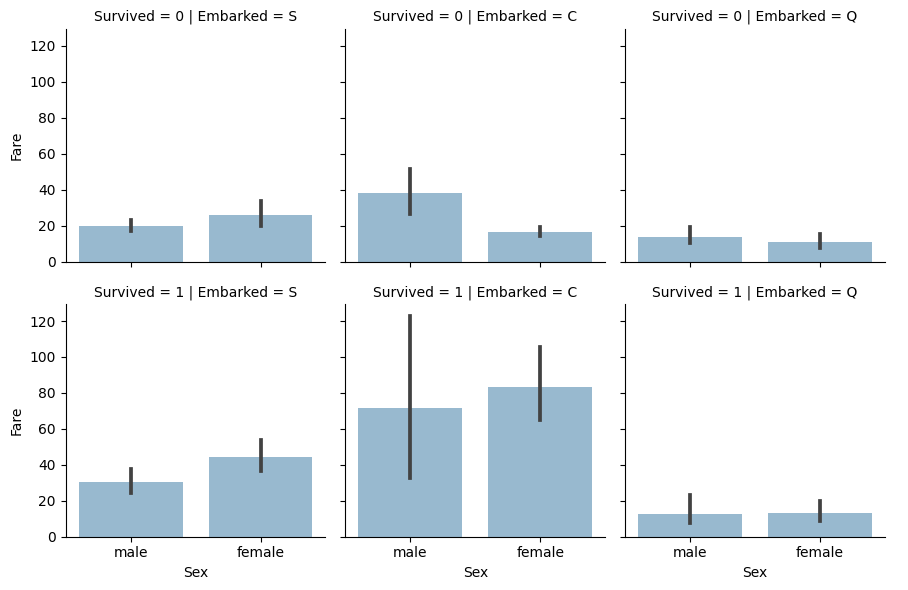

In [31]:
grid = sns.FacetGrid(passenger_df_train, col ='Embarked', row ='Survived')
grid.map(sns.barplot, 'Sex', 'Fare', alpha=.5,order=['male', 'female'])
grid.add_legend()

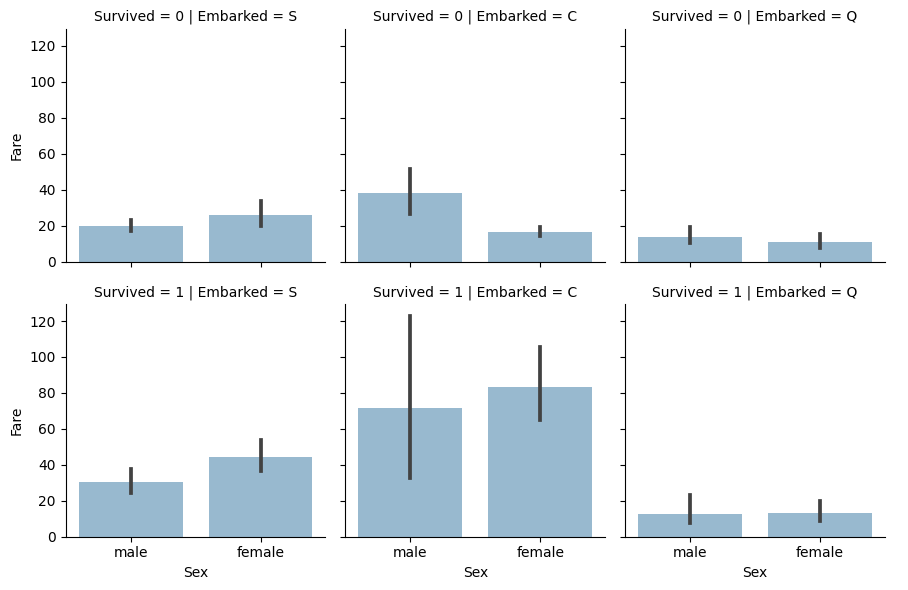

In [32]:
grid.fig

### Based on the Sex vs Fare vs Embarked vs Survived Barplots:

**<u>Observations</u>**

- Higher fare paying passengers had better survival. Confirms our assumption for creating (#4) fare ranges.
- Port of embarkation correlates with survival rates. Confirms correlating (#1) and completing (#2).

**<u>Decisions</u>**

- Consider banding Fare feature.

In [33]:
cabin_divide = passenger_df_train.copy()
cabin_divide['cabin_multiple'] = cabin_divide.Cabin.apply(lambda x: 0 if pd.isna(x) else len(x.split(' ')))

# letters
# multiple letters
cabin_divide['cabin_multiple'].value_counts()

cabin_multiple
0    687
1    180
2     16
3      6
4      2
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



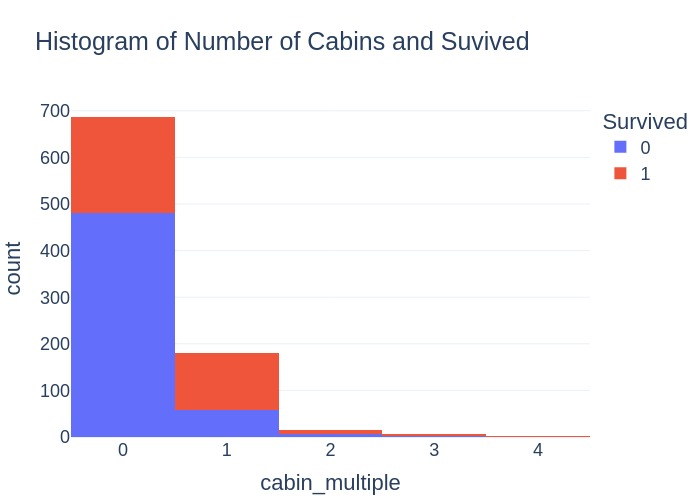

In [34]:
px.histogram(data_frame= cabin_divide, x="cabin_multiple", color="Survived",title='Histogram of Number of Cabins and Suvived')

Create categories based on the cabin letter (n stands for null). In this case we will treat null values like it's own category

In [35]:
cabin_divide['cabin_deck'] = cabin_divide.Cabin.apply(lambda x: str(x)[0])
#comparing survival rate by cabin
print(cabin_divide.cabin_deck.value_counts())

cabin_deck
n    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64


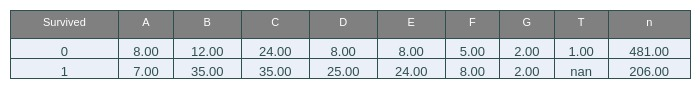

In [36]:
pd.pivot_table(cabin_divide,index='Survived',
               columns='cabin_deck', values = 'Name', 
               aggfunc='count').vu(r=0, i=1)

### Based on the Cabins Pivot Tables:

**<u>Observations</u>**

- Passengers with at least a Cabin listed to there ticket have a higher chance of surviving. Confirms engineering (#5)
- Cabin titles B,C,D,E and F have a higher chance of survival. Confirms engineering (#5) and debunks Filtering (#2)

**<u>Decisions</u>**

- Consider Seperating the cabin feature into only cabin letters.
- Consider creating a number of Cabins feature.

In [37]:
fig = px.histogram(cabin_divide,
                   facet_col="cabin_deck",
                   x="Pclass",
                   color="Survived",
                   title='Histogram of Pclass vs Deck vs Survived',
                   facet_col_wrap=3,
                   height=600)                  

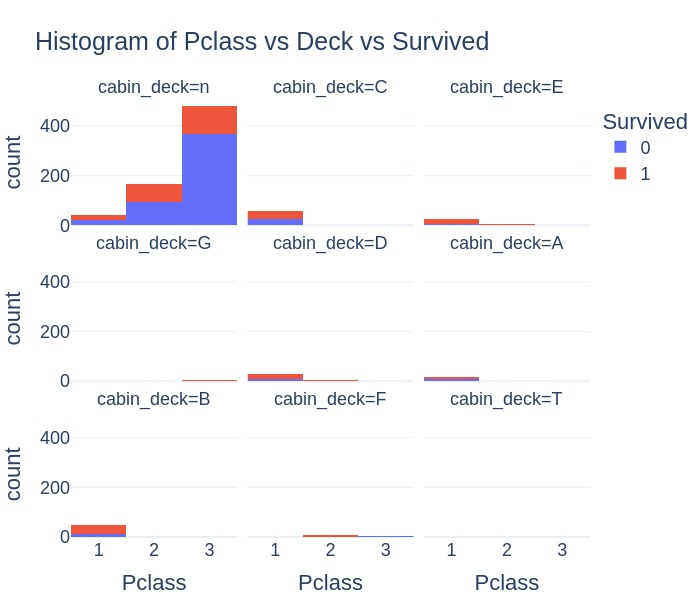

In [38]:
fig

**Ages vs ParCh**

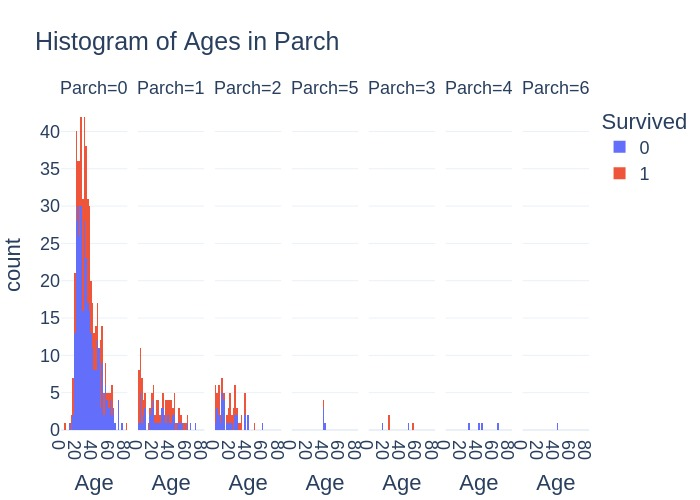

In [39]:
px.histogram(data_frame= passenger_df_train, facet_col="Parch",
             x="Age", color="Survived",title='Histogram of Ages in Parch')

## Exploration with no regard to Survival
For the purpose of this exploration and feature engineering we will unite training and testing data. The advantage of this is that we can perform same transformations on both datasets at the same time.
Since test set has all NaNs in Survived, we will mark it with "-1". This will later allow for splitting them back easily.  
During this exploration we will not touch "Survived" feature.  

In [40]:
co = {"Pclass": [1, 2, 3]}
original = ['Survived', 'Pclass', 'Name', 'Sex', 
            'Age', 'SibSp', 'Parch', 'Ticket',
            'Fare', 'Cabin', 'Embarked']

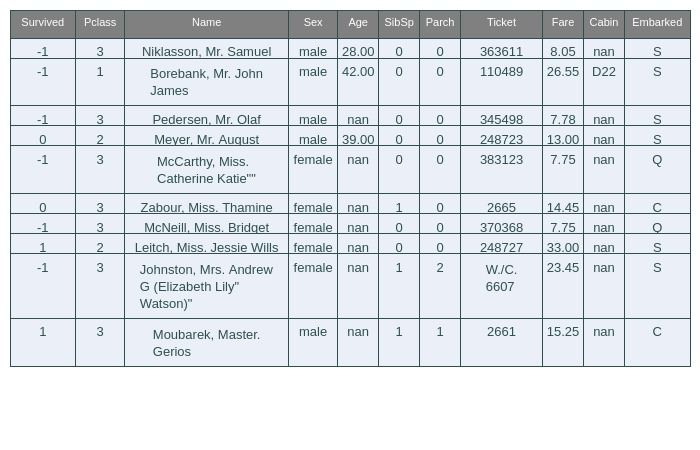

In [41]:
passenger_df.loc[passenger_df.Survived.isna(),"Survived"] = -1
passenger_df[original].vu(10)

### Cabin

Have Cabin: 22 %


/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



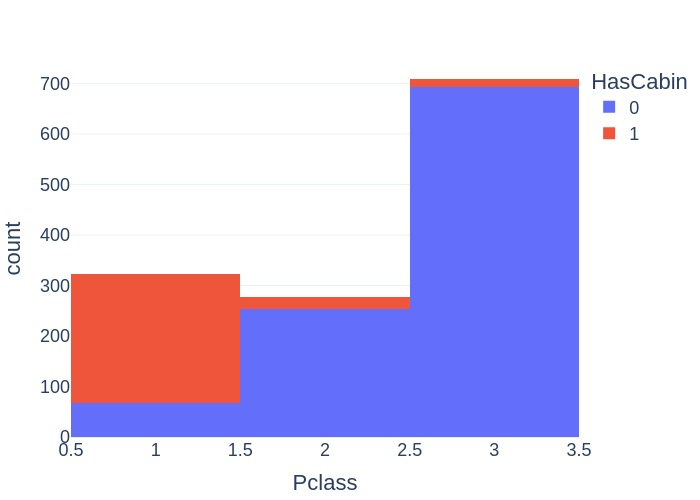

In [42]:
passenger_df["HasCabin"] = ~passenger_df.Cabin.isnull() *1
print("Have Cabin:" , int( passenger_df.HasCabin.sum() / passenger_df.shape[0] *100), "%" )
px.histogram(passenger_df, x = "Pclass", color="HasCabin")

We observe that the cabin column is the emptiest. Only 22% of 
the passengers have it, with the majority being in first class. 
Upon examining the Titanic deck plans, we see that all the living space was represented by cabins. We can conclude that the emptiness in data is not because those passengers did not have a cabin, but rather because this information was just not written down. In the chaos of a sinking ship, such inaccuracy is perfectly understandable.  


This sparsity of data usually disqualifies the column from a statistical model. However, some researchers ([CalebCastleberry](https://www.kaggle.com/code/ccastleberry/titanic-cabin-features), [Raj](https://www.kaggle.com/competitions/titanic/discussion/70943)) claim that including the column (while imputing the missing data) has allowed them to significantly increase the score of the model. Their approach to imputing the missing data was straightforward: replace it with mean value of cabin.  
While this approach is sound, our opinion is that it can be further improved.


For this purpose we need to split the Cabin column into it's components:
 - Letter (A through G + T) representing ship's deck
 - Cabin number
A fairly simple regular expression can be used for this.

In [43]:
passenger_df.drop("cDeck cNum".split(" "),axis=1, inplace=True, errors='ignore')

#rx = r'(?P<cDeck>[A-Za-z/.]+)?(?P<cNum>\d+)?$'
rx = r'(?P<cDeck>[A-Za-z])(?:\s[A-Za-z])?(?P<cNum>\d+)?$'
tspl = passenger_df.Cabin.str.extract(rx)
passenger_df = passenger_df.join(tspl)

#---
# Why am I doing this step? F deck has slightly different cabins allocation.
# There is an F section in the aft of ship, which starts counting from number
# one again. To make these cabins conform to general structure of cabins
# numbering that I've accepted here, I increase cabin F33 number by 70,
# so the number indicates the cabin is in the aft of ship.
passenger_df.loc[passenger_df.Cabin == "F33","cNum"] = 103
#---

passenger_df.loc[passenger_df.Fare.isna(),'Fare'] = 10
passenger_df.loc[passenger_df.cDeck.isna(),'cDeck'] = 'n'
decks = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', 'n']
passenger_df.cDeck = pd.Categorical(passenger_df.cDeck,
                              categories=decks,
                              ordered=True)


Validate that deck and cabin got split correctly by comparing original column Cabin with the reconstructed column cCheck.

In [44]:
passenger_df['cCheck'] =  (passenger_df['cDeck']).astype(str) +  passenger_df['cNum'].astype(str)
passenger_df.loc[passenger_df.cCheck=='nnan',"cCheck"] = np.NaN
check = passenger_df[~(passenger_df['Cabin'] == passenger_df['cCheck'])].sort_values("Cabin")

columns_of_interest =  "Name Sex Age Pclass Fare HasCabin Cabin cCheck cDeck cNum".split(" ")

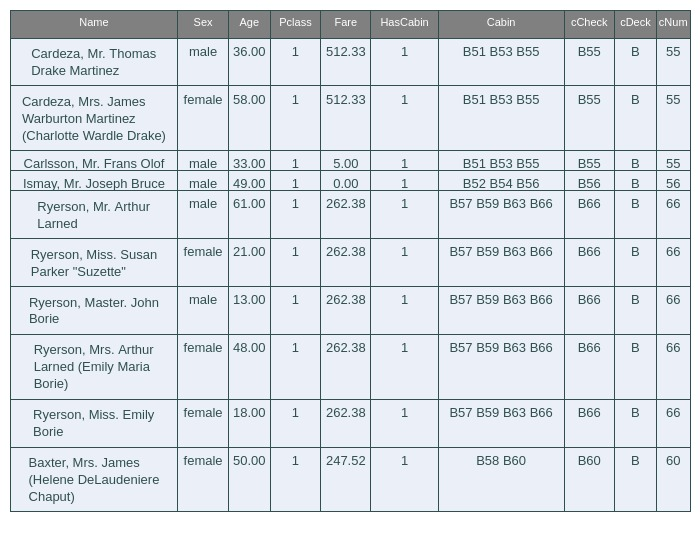

In [45]:
check.loc[check["HasCabin"]==1, columns_of_interest ].vu(r=0)

Some cabins seem to not have splitted correctly. Mostly, those having several cabins listed per person. However, upon examining these cabins we can conclude that these are families occupying several (1st class) cabins close to each other. Our splitting method takes one of the cabins from each such group, essentially "squeezing" the whole family in one cabin. Hence, we deem our splitting method as good enough for this case. 

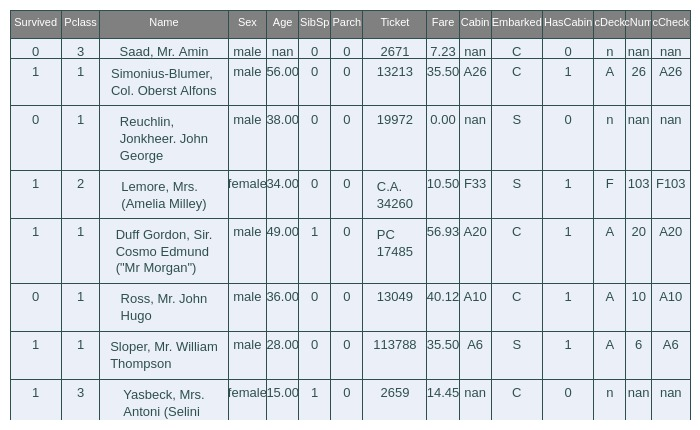

In [46]:
interesting_passengers = [823,  831,  829,  828,  827,  826,  825,  822,  833,
                          584,  938,  600,  285,   24, 1266, 1185,  648,
                          1001, 129, 1180, 1213, 873, 1114, 67, 517, 346]
passenger_df.loc[interesting_passengers].vu()


### Ticket/placement
Explore what we can find from ticket/ placement data.  
Columns involved:   
`Fare`, `Cabin`, `Pclass`, `Embarked`, `Ticket`

In [47]:
passenger_df.drop("tPref tNum".split(" "),axis=1, inplace=True, errors='ignore')

rx = r'(?P<tPref>[A-Za-z/.\d]+\s(?:[A-Za-z.\d]+\s)?)?(?P<tNum>\d+)$'

tspl = passenger_df.Ticket.str.extract(rx)
passenger_df = passenger_df.join(tspl)

In [48]:
passenger_df.loc[passenger_df['Ticket'] == "LINE", "tPref"] = "LINE"
passenger_df.loc[passenger_df['Ticket'] == "LINE", "tNum"] = 1
passenger_df.tNum = passenger_df.tNum.astype(int)
passenger_df.loc[passenger_df.tPref.isna(), "tPref"] = ''

Validate: all tickets got split correctly?

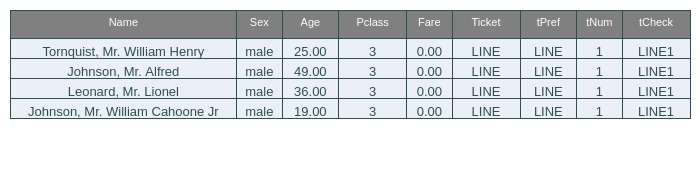

In [49]:
passenger_df["tCheck"] =  (passenger_df['tPref']).fillna('') + "" +passenger_df['tNum'].astype(str)

columns_of_interest =  "Name Sex Age Pclass Fare Ticket tPref tNum tCheck".split(" ")
passenger_df.loc[passenger_df['Ticket'] != passenger_df["tCheck"], columns_of_interest].vu(4)

Only 4 tickets have splitted incorrectly. But they have no ticket number in the first place, so it does not matter.

#### Analyzing ticket prefixes
It seemed that ticket prefixes could contain additional information encoded in them. Our theory was that somehow it could be indicative of placement on the ship.  

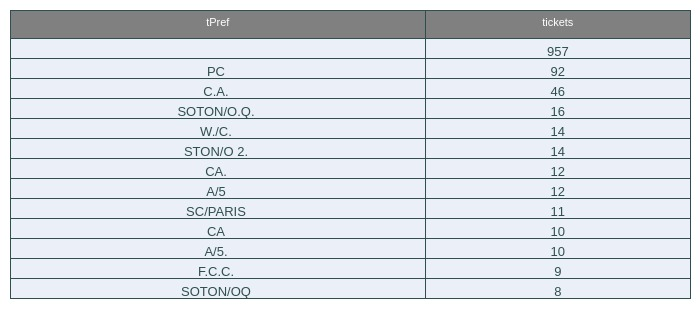

In [50]:
q = """
Select tPref, count(Ticket) as tickets
from passenger_df
group by tPref
order by tickets desc
limit 13
"""
ps.sqldf(q).vu(13,r=False)

Having extracted and summarized the prefixes, we observed that a lot of these prefixes were identical among some tickets.  
Also, by eliminating special characters, some different prefixes 
could be merged into one, e.g  
`(C.A. , CA. , CA) => CA`

In [51]:
def tr(val):
    val = val.replace(".","")
    val = val.replace("/","")
    val = val.replace(" ","")
    val = val.replace("STON","")
    val = val.replace("SOTON","")
    val = val.replace("PARIS","")
    val = val.replace("Paris","")
    val = val.replace("Basle","")
    val = val.replace("AH","")
    return val


passenger_df['tPrefTr'] = passenger_df.tPref.apply(tr)

prefs = passenger_df.groupby('tPrefTr').count().sort_values('tPrefTr', ascending=True)
co["tPrefTr"] = prefs.index.values

In [52]:
q = """
select count( distinct tPref) utPref, count( distinct tPrefTr) utPrefTr 
from passenger_df
"""
ps.sqldf(q)

utPref  utPrefTr
0      52        30

By performing this transform, we've reduced the amount of unique prefixes from 52 to 30 

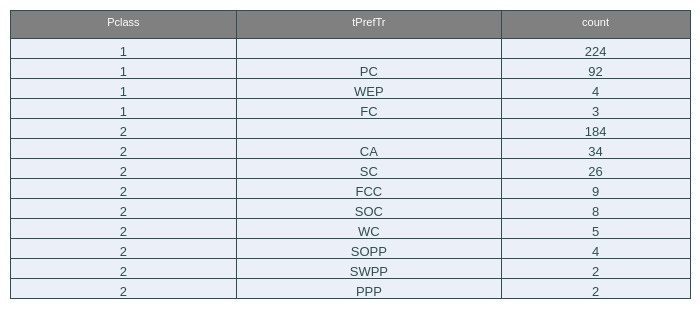

In [53]:
q = """
select Pclass, tPrefTr, count(*) as count
from passenger_df
group by Pclass, tPrefTr
order by Pclass, count desc
limit 13
"""
ps.sqldf(q).vu(13, r=False)

According to forums dedicated to Titanic, PC, FC mean Private Class and First CLass.  
Unfortunately, we could not guess what most of the rest mean, and no clues were found on the Internet.

#### Hypothesis: ticket number has meaning
During exploration We had another hipothesis, that ticket number could somehow contain an encoding to placement of the passenger on the ship.
To explore this hypothesis, we created various plots of features that might be involved, such as:
- Ticket number
- Ticket prefix
- Fare
- Class
- Deck
- Cabin number

Ticket numbers seem to be concentrated into several groups. Encyclopedia Titanica Forum suggest that these groups come from individual stores from which the tickets were purchased. The order inside group is probably the order in which the tickets were purchased, so probably not very relevant to current research.

Zooming down into distributions of passengers with cabins vs. those who had no cabin registered, we were wondering if deck and/or cabin number could somehow be "encoded" in Fare and ticket number. To check this out we've built the following plot:

In [54]:
passenger_df['ClassDeck'] = passenger_df['Pclass'].astype(str) + passenger_df['cDeck'].astype(str)

co["ClassDeck"] =  passenger_df["ClassDeck"].sort_values(ascending=False).unique()

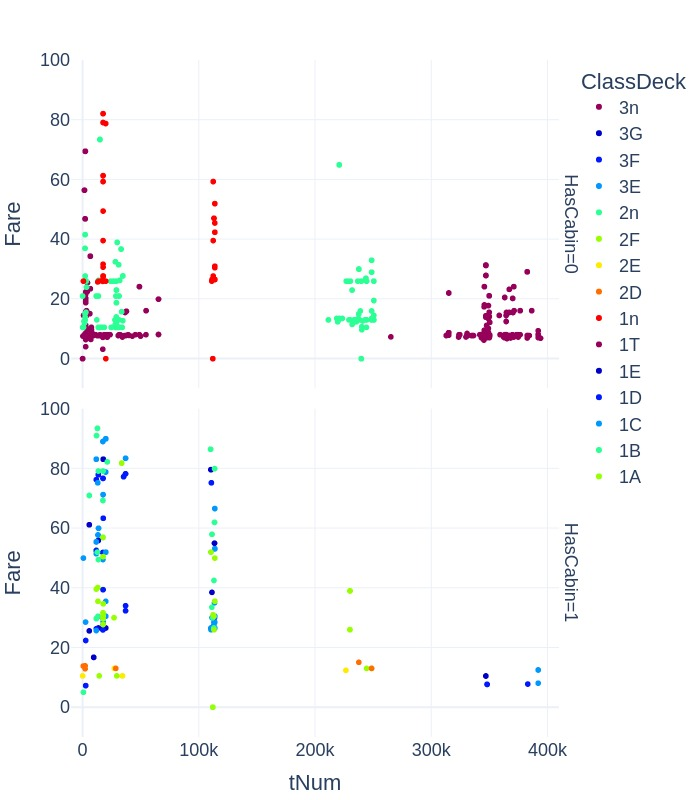

In [55]:
fig = px.scatter(passenger_df, x = "tNum", y = "Fare", color="ClassDeck", facet_row="HasCabin", \
           color_discrete_sequence= px.colors.sequential.Rainbow, category_orders=co ,
           height=800, range_x= [-10000, 4.1e5], range_y=[-10,100])
fig

At first glance, the fares and ticket numbers are clearly distributed into a number of distinct clusters, which appear to have some relation with composite variable ClassDeck. 
However the available data for classes 2 and 3 turned out to be too sparse to provide a reliable basis for an estimator for missing data.  
Hence, we decided to abandon the Cabin variable in the end.  

### Age

In [56]:
print( int(passenger_df[passenger_df.Age.isna()].shape[0] / passenger_df.shape[0] *100) , "%")

20 %


We observe that about 20% of passengers have no age registered. We think that it could be estimated from other features, such as Title, amount of children/siblings, etc

### Name
There appears to be a lot of information contained in passengers names. Let us check, what can be extracted from it.  
First, let's see what tokens beside names we can expect to see in this column

In [57]:
def spl(n):
    return  n.split(" ")

In [58]:
names = passenger_df_train.Name.apply(func=spl).values.tolist()
words = sum(names,[])

unique, counts = np.unique(words, return_counts=True)
wc = pd.DataFrame({"token":unique, "count": counts})

tokens = wc.sort_values("count",ascending=False)

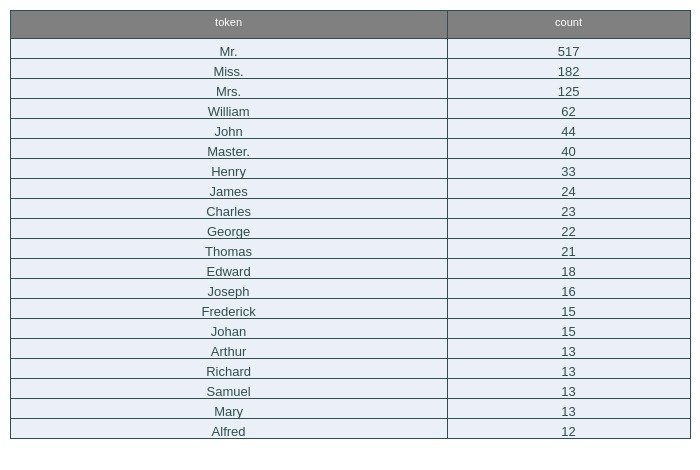

In [59]:
tokens.vu(20,0)

24% of tokens in in the whole Name column are the following tokens

In [60]:
ttls = tokens[tokens.token.str.contains('\\.', )]
perc = int(ttls["count"].sum()/ tokens["count"].sum() *100)
perc = f"{perc}% of tokens in in the whole Name column are represented by the following tokens:"

In [61]:
fig = px.bar(ttls, y = "token", x ="count", ).\
    update_layout(height=600).\
    update_yaxes(autorange='reversed')

24% of tokens in in the whole Name column are represented by the following tokens:


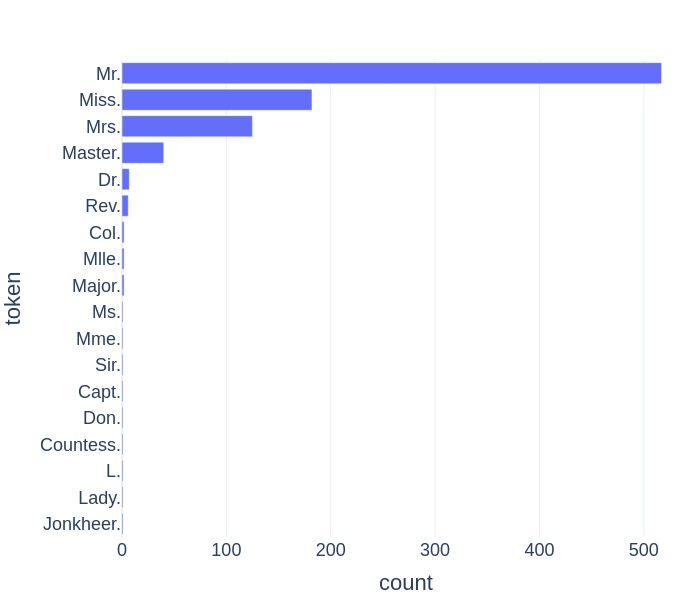

In [62]:
print(perc)
fig


We see that people's titles have high token frequencies, suggesting that lots of people have them. Moreover, the Name column appears to have a very consistent structure:  
`Last_name, Title. First_Name (Second_Name)`  
This allows to split the Name column into its components using a relatively simple regular expression :) .

In [63]:
passenger_df.drop("lName Title fName sName".split(" "),axis=1, inplace=True, errors='ignore')
coi = ['Pclass', 'Name', 'Sex', 'Age', 'lName', 'Title', 'fName', 'sName']

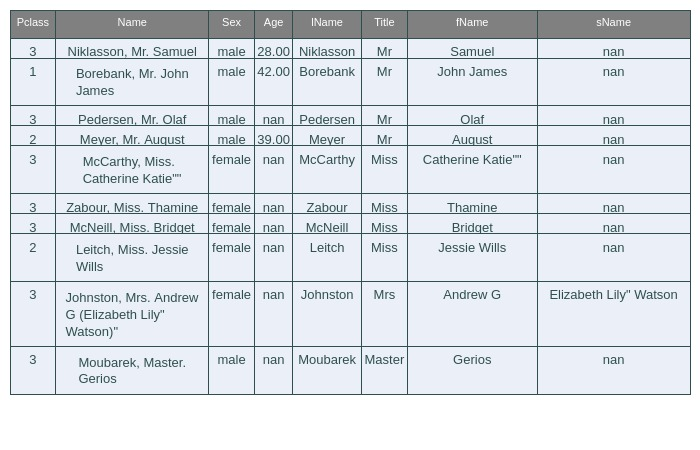

In [64]:
rx = r"^(?P<lName>[A-Za-z\s'-]+),\s(?P<Title>[A-Za-z\s]+)"
rx+= r"\.(?:\s(?P<fName>[A-Za-z\s\/\"]+))?(?:\s\((?P<sName>[A-Za-z\s\"'\.-]+)\).*)?$"
nspl = passenger_df.Name.str.extract(rx)
passenger_df = passenger_df.join(nspl)
passenger_df[coi].vu(10)

#### Title  
Let us further explore the title column.

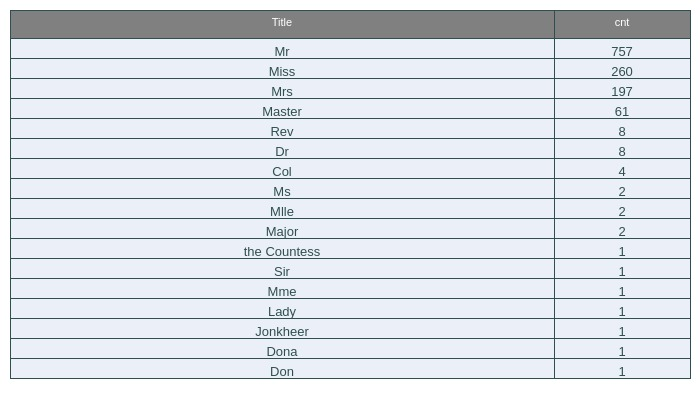

In [65]:
q = """
select Title, count(*) as cnt
from passenger_df
group by Title
order by cnt desc
"""
ps.sqldf(q).vu(17,0)

We have 17 titles in total, most of which are common: Mr, Mrs, Miss and Master, with the rest being rare:  

Several military titles, as well as other relarted to person's occupation. These can be joined into a single category Rare:  
- Col, Major, Jonkeer, Capt.
- Rev is Reverend - a member of clergy  
- Dr is Doctor  
Some titles are the equivalents of common titles in other languages or alternative spelling:  
 - Ms, Mlle = Miss  
 - Mme = Mrs
Several people have a noble title. But since they are few, they can be joined into Mr, Mrs category.  
 - the Countess, Lady, Dona = Mrs  
 - Don, Sir = Mr  


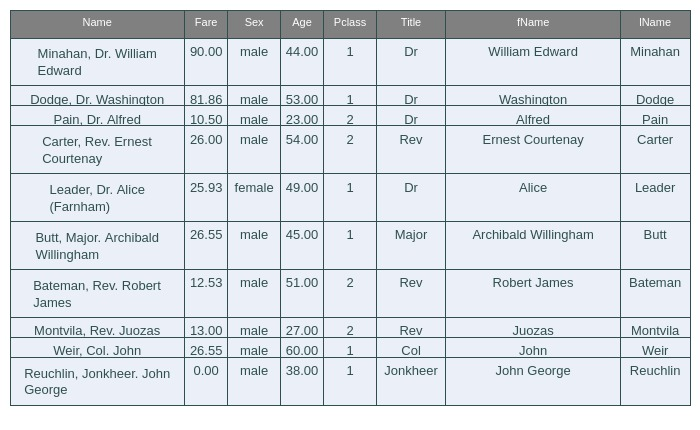

In [66]:
coi = "Name Fare Sex Age Pclass Title fName lName".split(" ")
rare = passenger_df.Title.isin(["Col", "Major", "Jonkheer", "Capt", "Dr", "Rev"])
passenger_df.loc[rare, coi].sort_values("Age").vu()

In [67]:
passenger_df.loc[passenger_df.Title.isin(["Col", "Major", "Jonkheer", "Capt", "Dr", "Rev"]), "Title"] = "Rare"
passenger_df.loc[passenger_df.Title.isin(["Mme", "the Countess", "Lady", "Dona"]), "Title"] = "Mrs"
passenger_df.loc[passenger_df.Title.isin(["Ms", "Mlle"]), "Title"] = "Miss"
passenger_df.loc[passenger_df.Title.isin(["Don", "Sir"]), "Title"] = "Mr"

After the replacing we have just 5 categories in title:

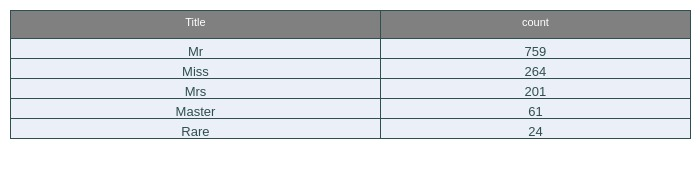

In [68]:
q = """
select Title, count(*) as count
from passenger_df
group by Title
order by count desc
"""
ps.sqldf(q).vu(5,0)

We think that this may be used to estimate Age where it's unknown

#### Second name  
Let's explore the second name (sName column):

In [69]:
coi = "Fare Sex Age Pclass Title fName lName sName".split(" ")

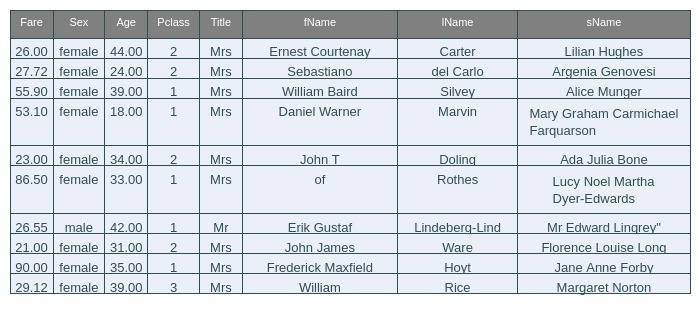

In [70]:
passenger_df.loc[~passenger_df.sName.isna(),coi].vu(10)

We perform a similar token analysis  with these as with the full name before

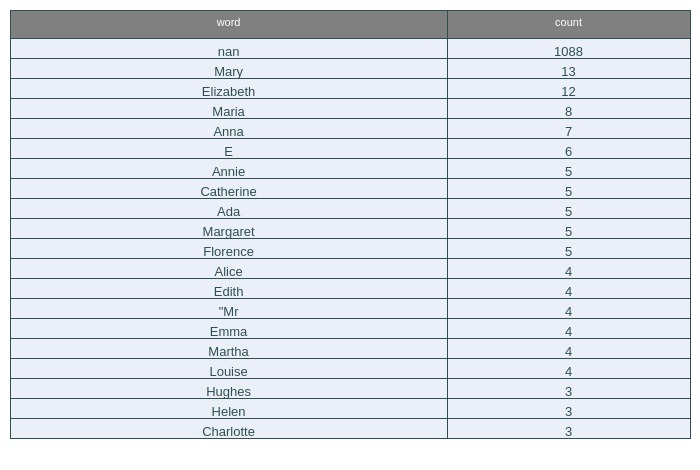

In [71]:
names = passenger_df.sName.astype(str).apply(func=spl).values.tolist()
words = sum(names,[])

unique, counts = np.unique(words, return_counts=True)
wc = pd.DataFrame({"word":unique, "count": counts})
tokens = wc.sort_values("count",ascending=False)
tokens.vu(20,0)

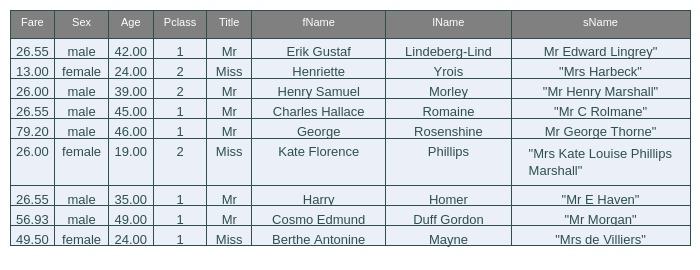

In [72]:
passenger_df.loc[passenger_df.sName.astype(str).str.contains("Mr"), coi].vu(9)

Seems like majority of these contain full/maiden names of women travelling with ticket under their husbands' names.  
Maybe this property could be used to separate SibSp column into Siblings and Spouses and ultimately, for Age estimation.

### Family composition data

Upon acqiring these new columns, we can plot them on a graph and discover an interesting pattern:  
 - The title Master, meaning underage male, is concentrated in lower age range,
 - The title Miss, meaning underage or unmarried female, is concentrated higher
 - The Mrs and Mr are grownups.

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



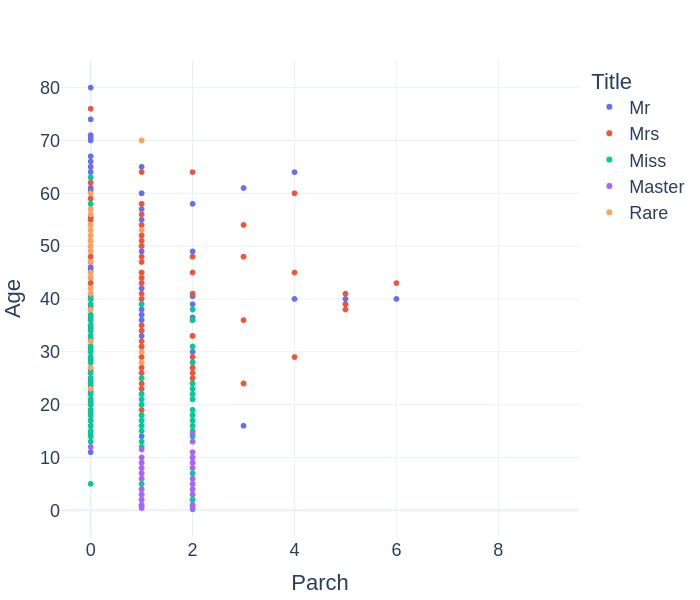

In [73]:
px.scatter(passenger_df, y = "Age", x = "Parch", color="Title", hover_data=["Fare", "Name"], \
          category_orders=co, height= 600 )

We think that the titles, along with the amount of parents and siblings, can serve as a good indicator for person's age.

### Some interaction variables

In [74]:
passenger_df["SexClass"] =  passenger_df["Pclass"].astype(str) + passenger_df["Sex"]

co["SexClass"] = passenger_df["SexClass"].sort_values().unique()
co["Parch"] = [0,1,2,3,4,5,6,7,8,9]

In [75]:
passenger_df["EmbClass"] = passenger_df.Pclass.astype(str) + passenger_df.Embarked
co["EmbClass"] = passenger_df["EmbClass"].sort_values().unique()
co["EmbClass"]

array(['1C', '1Q', '1S', '2C', '2Q', '2S', '3C', '3Q', '3S', nan],
      dtype=object)

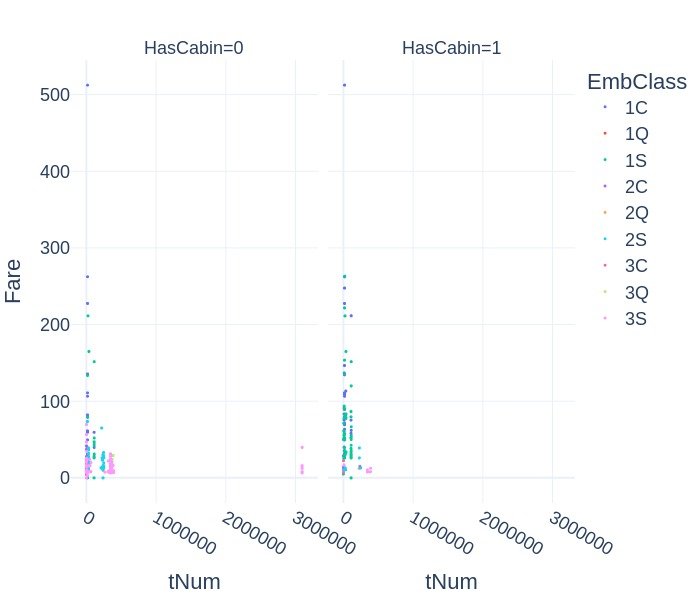

In [76]:

fig = px.scatter(passenger_df, x = "tNum", y = "Fare", color="EmbClass", facet_col = "HasCabin", \
                 hover_data=[passenger_df.index,"Cabin","Embarked","Fare","Pclass","cNum", "tPrefTr"], \
                 height=600, category_orders=co, \
                )

fig.update_xaxes(categoryorder='category ascending')
fig.update_traces(marker_size = 3)
fig.update_yaxes(tickformat="%f")
fig.update_xaxes(tickformat="%f")

## Part 2 - Data Engineering + Encoding Categorical Values

## Data Imputation

As discussed in Exploration section, about 20% of passengers have no Are registered. We would like to impute the null values of Age with an estimate based on other variables.

**Prepare dataset for training and imputation**  

Convert categorical variables into dummy variables using one-hot encoding

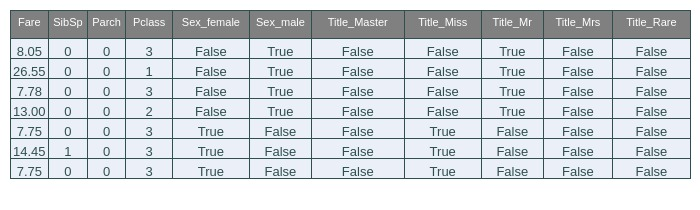

In [77]:
Cx = ["Fare", "Sex", "SibSp", "Parch", "Pclass", "Title"]
Cy = "Age"
categorical_columns = ["Sex", "Title"]
X = pd.get_dummies(passenger_df[Cx], columns=categorical_columns)
y = passenger_df[Cy]
X.vu(7)

Select rows with missing values for 'Age'. Those will be imputed

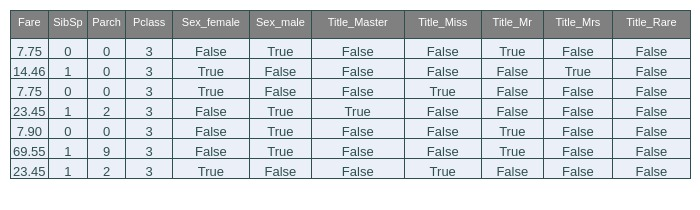

In [78]:
Ximp = X[y.isna()]
yimp = y[y.isna()]
Ximp.vu(7)

Select rows with existing values for 'Age' in target. Those will be used to learn the pattern for imputation

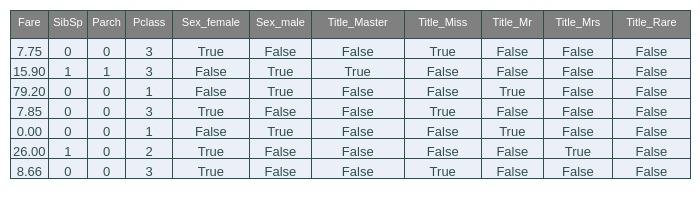

In [79]:
X = X[~y.isna()]
y = y[~y.isna()]
X.vu(7)

And split the Dataset into Train and Validation 

In [80]:
def i_trn_tst_val(X, test_size=0.1):
    i_trn, i_val =  next(model_selection.ShuffleSplit(test_size=test_size, random_state=42).split(X))
    return i_trn, i_val

In [81]:
i_trn, i_val = i_trn_tst_val(X, test_size=0.1)

### Cross-validate ensemble models
We need to train a model that will predict Age of a person best.  
At this stage we will concentrate on ensemble family of models
This convenience function will be used for training, evaluation  and summarization  of various ML models.  


In [82]:
newpath = r'CV_Runs'
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [83]:
def Report(cv_run):
    print("Elapsed Time:", cv_run["elapsed"])
    print("====================")
    print("Best Score: {:.3f}".format(grid.best_score_))
    print("Best Parameters: {}".format(grid.best_params_))

In [84]:
CV_Runs = []
import time

def Run_and_Report(grid, X, y):
    start_time = time.time()
    grid.fit(X.iloc[i_trn], y.iloc[i_trn])
    stop_time = time.time()
    
    params = grid.get_params()
    best = grid.best_estimator_
    cv_run = {
        "timestamp": datetime.now().strftime("%Y-%m-%d_%H-%M-%S"),
        "elapsed": time.strftime("%H:%M:%S",time.gmtime(stop_time - start_time)),
        "estimator": str(params['estimator']),
        "best_params": grid.best_params_,
        "train_score": best.score(X.iloc[i_trn], y.iloc[i_trn]),
        "val_score":   best.score(X.iloc[i_val], y.iloc[i_val]),
        "cv": params['cv'],
        "n_iter": params["n_iter"],
        "n_jobs": params["n_jobs"],
        "CVmethod": type(grid).__name__,
        "param_grid": params['param_distributions'],
        "features": X.columns.tolist(),
        "target": y.name
    }
    CV_Runs.append(cv_run)
    with open(f"CV_Runs/{cv_run['timestamp']}.json", 'w') as f:
        json.dump(cv_run, f, default=lambda x: x.__repr__())
    Report(cv_run)

**Random Forest**

In [85]:
rfr = RandomForestRegressor()
param_grid ={'max_depth': st.randint(6, 20),
             'n_estimators': st.randint(10, 500),
             'max_features': np.arange(5, 12),
             'max_leaf_nodes': st.randint(6, 30)}
grid = model_selection.RandomizedSearchCV(rfr,
                    param_grid, cv=10,
                    verbose=1, n_iter=iterations, n_jobs=16,  )
Run_and_Report(grid, X, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Elapsed Time: 00:00:32
Best Score: 0.435
Best Parameters: {'max_depth': 19, 'max_features': 7, 'max_leaf_nodes': 20, 'n_estimators': 160}


In [86]:
#TODO: apply correct scoring for the models. 
# use `scoring` parameter of the RandomizedSearchCV Class
#rfr.score(

**AdaBoost**

In [87]:
abr = AdaBoostRegressor()
param_grid ={
    'learning_rate': st.randint(1, 10),
    'n_estimators': st.randint(10, 500),
}
grid = model_selection.RandomizedSearchCV(abr,
                    param_grid, cv=10,
                    verbose=1, n_iter=iterations, n_jobs=16 )
Run_and_Report(grid, X, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Elapsed Time: 00:00:02
Best Score: 0.382
Best Parameters: {'learning_rate': 1, 'n_estimators': 400}


**GradientBoosting**

In [88]:
gbr = GradientBoostingRegressor()
param_grid ={'max_depth': st.randint(6, 20),
             'n_estimators': st.randint(10, 500),
             'max_features': np.arange(5,12),
             'max_leaf_nodes': st.randint(6, 30)}
grid = model_selection.RandomizedSearchCV(gbr,
                    param_grid, cv=10,
                    verbose=1, n_iter=iterations, n_jobs=16 )
Run_and_Report(grid, X, y)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Elapsed Time: 00:00:13
Best Score: 0.438
Best Parameters: {'max_depth': 10, 'max_features': 11, 'max_leaf_nodes': 8, 'n_estimators': 103}


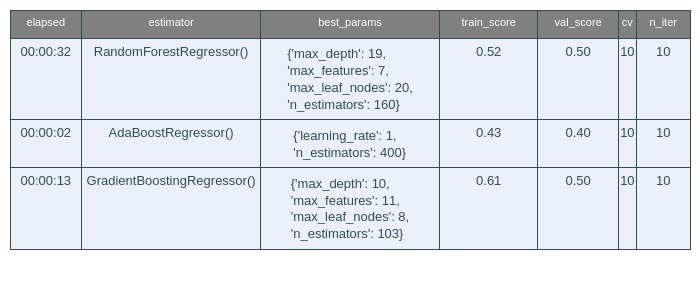

In [89]:
CV_df = pd.DataFrame(CV_Runs)
CV_df[['elapsed', 'estimator', 'best_params', 'train_score',
       'val_score', 'cv', 'n_iter']].vu(r=0)

In [90]:
# TODO: fix this plot

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



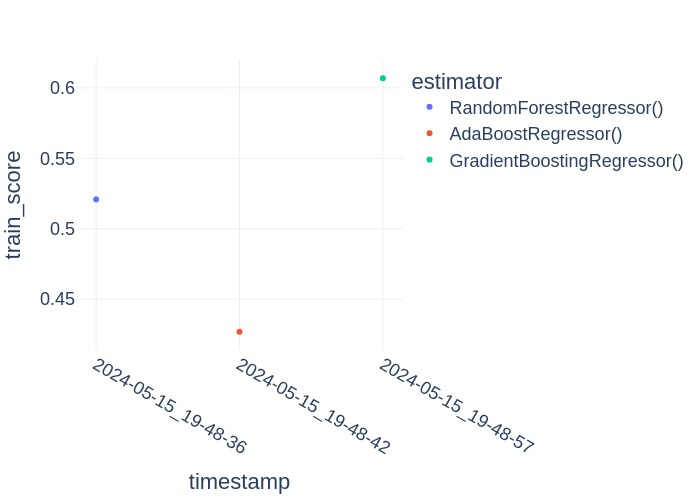

In [91]:
fig = px.scatter(CV_df, x="timestamp", y="train_score", color="estimator")
fig

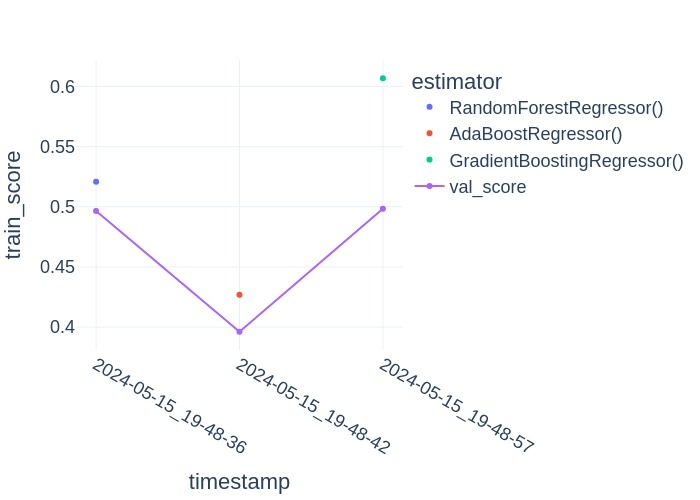

In [92]:
fig.add_trace( go.Scatter(x=CV_df["timestamp"], y=CV_df["val_score"], name="val_score", )) #, fill=CV_df["estimator"]))

fig

### Estimate missing ages
Based on the benchmarking results above, we decided to choose model 3 (GradientBoostingRegressor)

In [93]:
df = CV_df.loc[2,["estimator", "best_params"]]
with pd.option_context('display.max_rows', None, 'display.max_colwidth', None):
    print(df)

estimator                                                          GradientBoostingRegressor()
best_params    {'max_depth': 10, 'max_features': 11, 'max_leaf_nodes': 8, 'n_estimators': 103}
Name: 2, dtype: object


In [94]:

best_params = {'max_depth': 13, 'max_features': 5, 'max_leaf_nodes': 29, 'n_estimators': 435}

rfc = GradientBoostingRegressor(**best_params)
rfc.fit(X,y)
y_hat = rfc.predict(Ximp)
y_hat = pd.Series(rfc.predict(Ximp), index=Ximp.index)

Impute the new predicted age values into original dataset and visually compare distributions of existing and estimated ages

In [95]:
passenger_df.loc[y_hat.index, "Age"] = y_hat.astype(int)
passenger_df["AgeEstimated"] = 0
passenger_df.loc[y_hat.index, "AgeEstimated"] = 1

/opt/conda/lib/python3.10/site-packages/plotly/express/_core.py:2065: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



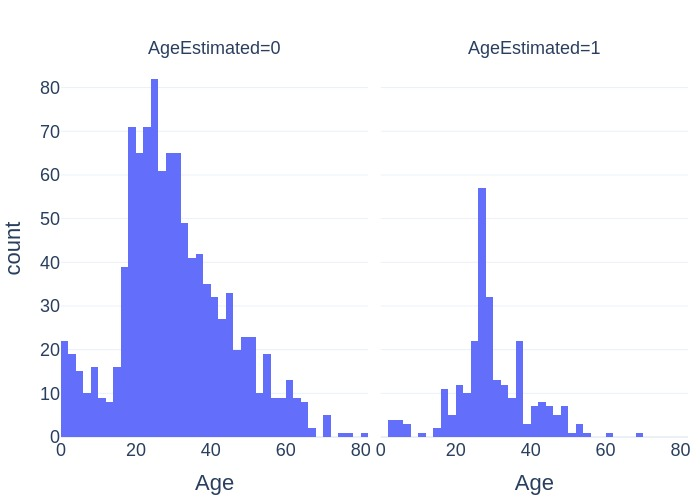

In [96]:
px.histogram(passenger_df, x="Age", facet_col = "AgeEstimated")

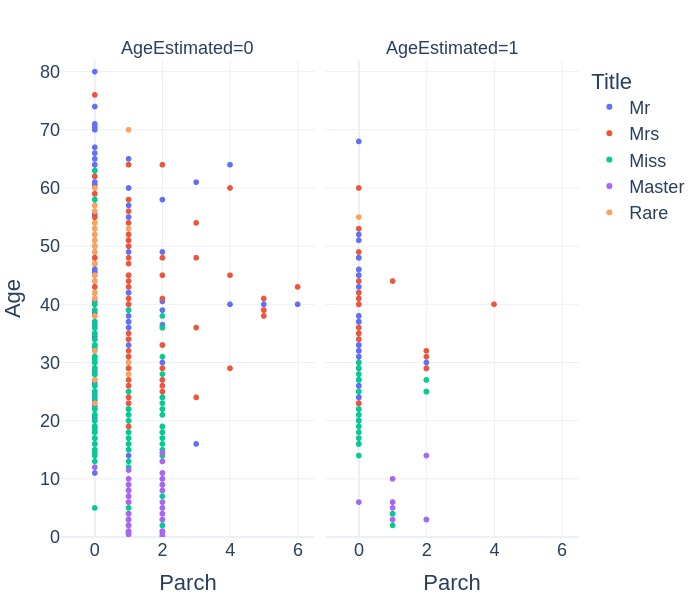

In [97]:
px.scatter(passenger_df, y = "Age", x = "Parch", color="Title", facet_col= "AgeEstimated",
           hover_data=["SibSp", "Fare", "Name"], range_x=[-1,6.5], range_y = [0,82],
           category_orders=co, height= 600)

It seems that imputation went quite well.

## Construct More features
The length of the Name

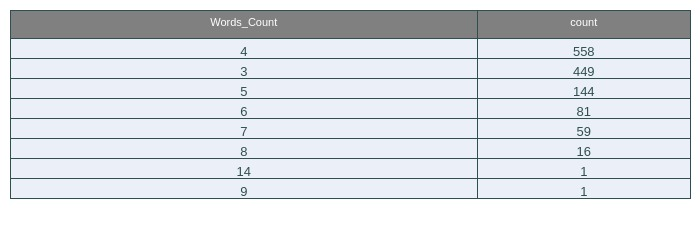

In [98]:
passenger_df['Words_Count'] = passenger_df['Name'].apply(lambda x: len(x.split()))
pd.DataFrame(passenger_df.Words_Count.value_counts()).vu(r=0,i=1)

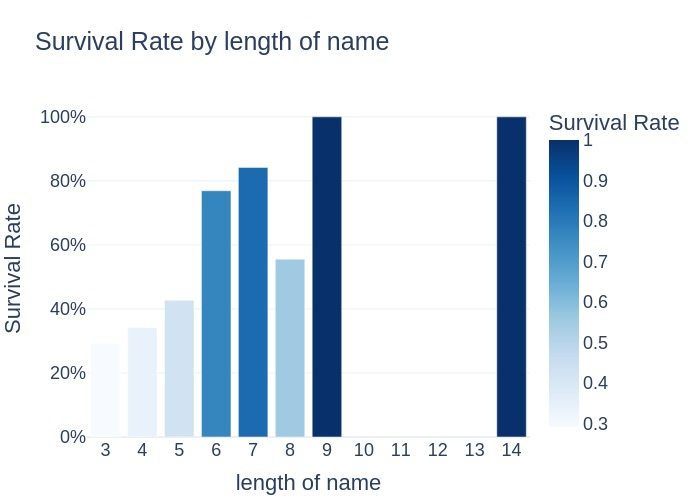

In [99]:
# Your DataFrame and calculation
data = passenger_df[passenger_df.Survived != -1][['Words_Count', 'Survived']].groupby(['Words_Count'], as_index=False).mean().sort_values(by='Survived', ascending=False)

# Create a bar plot using Plotly Express
fig = px.bar(data, x='Words_Count', y='Survived', title='Survival Rate by length of name',
             labels={'Words_Count': 'length of name', 'Survived': 'Survival Rate'},
             color='Survived', color_continuous_scale='blues')

# Update layout
fig.update_layout(xaxis=dict(tickmode='linear'), yaxis_tickformat=',.0%')

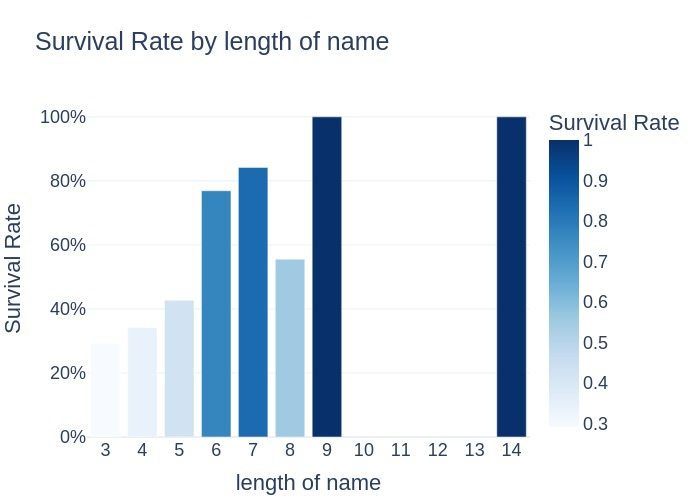

In [100]:
fig

Creating new features:
 - cabin_multiple: number of cabins each passenger had.
 - cabin_deck: the ship's deck where cabnin is located  
 - FamilySize as a combination of SibSp and Parch  
 - IsAlone from FamilySize  

In [101]:
from IPython.display import HTML

def side_by_side(*dfs):
    html = '<div style="display:flex">'
    for df in dfs:
        html += '<div style="margin-right: 2em">'
        html += df.to_html()
        html += '</div>'
    html += '</div>'
    display(HTML(html))

In [102]:
passenger_df['cabin_multiple'] = passenger_df['Cabin'].apply(
    lambda x: 0 if pd.isna(x) else len(x.split(' ')))
passenger_df['cabin_deck'] = passenger_df['Cabin'].apply(lambda x: str(x)[0])

passenger_df['FamilySize'] = passenger_df['SibSp'] + passenger_df['Parch'] + 1
df1 = passenger_df[passenger_df.Survived != -1][['FamilySize', 'Survived']].groupby(
    ['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)

passenger_df['IsAlone'] = 0
passenger_df.loc[passenger_df['FamilySize'] == 1, 'IsAlone'] = 1
df2 = passenger_df[passenger_df.Survived != -1][['IsAlone', 'Survived']].groupby(
    ['IsAlone'], as_index=False).mean().sort_values(by='Survived', ascending=False)

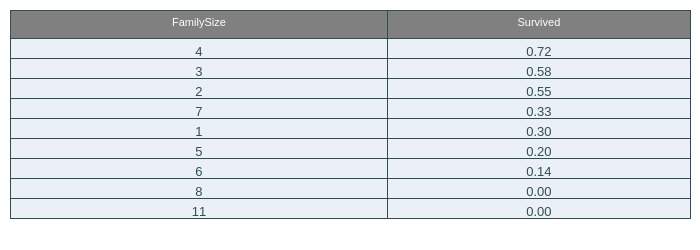

In [103]:
df1.vu(r=0)

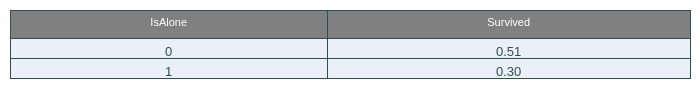

In [104]:
df2.vu(r=0)

Remove all NULLS in the Fare column and Create new feature CategoricalFare

In [105]:
passenger_df['Fare'] = passenger_df['Fare'].fillna(passenger_df['Fare'].median())
passenger_df['CategoricalFare'] = pd.qcut(passenger_df['Fare'], 6)
df = passenger_df[passenger_df.Survived != -1][['CategoricalFare', 'Survived']].groupby(
    ['CategoricalFare'], as_index=False).mean().sort_values(
    by='CategoricalFare', ascending=True)

/tmp/ipykernel_18/3724020141.py:3: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [106]:
df

CategoricalFare  Survived
0  (-0.001, 7.775]      0.21
1   (7.775, 8.662]      0.19
2  (8.662, 14.454]      0.37
3   (14.454, 26.0]      0.44
4     (26.0, 53.1]      0.44
5  (53.1, 512.329]      0.70

[Deprecated] Impute missing Age values with random 

In [107]:

#age_avg = passenger_df_train['Age'].mean()
#age_std = passenger_df_train['Age'].std()
#age_null_count = passenger_df_train['Age'].isnull().sum()
#age_null_random_list = np.random.randint(age_avg - age_std, age_avg + age_std, size=age_null_count)
#age_null_random_list = pd.Series(age_null_random_list, index = passenger_df_train[passenger_df_train['Age'].isnull()].index)

#passenger_df_train["Age"].fillna(age_null_random_list, inplace=True)


Create a New feature CategoricalAge

In [108]:
passenger_df['CategoricalAge'] = pd.qcut(passenger_df['Age'], 6)
df = passenger_df[passenger_df.Survived != -1][['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean().sort_values(by='CategoricalAge', ascending=True)

/tmp/ipykernel_18/2896104425.py:2: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [109]:
df.head(8)

CategoricalAge  Survived
0  (0.169, 18.0]      0.50
1   (18.0, 24.0]      0.36
2   (24.0, 28.0]      0.32
3   (28.0, 34.0]      0.36
4   (34.0, 43.0]      0.39
5   (43.0, 80.0]      0.36

## Mapping Categorical and High Ordinal Features

In [110]:

# Mapping Sex
passenger_df['Sex'] = passenger_df['Sex'].map( {'female': 0, 'male': 1} ).astype(int)

# Mapping Titles
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
passenger_df['Title'] = passenger_df['Title'].map(title_mapping)
passenger_df['Title'] = passenger_df['Title'].fillna(0)


# Remove all NULLS in the Embarked column (2 nulls)
passenger_df['Embarked'] = passenger_df['Embarked'].fillna('S')
# Mapping Embarked
passenger_df['Embarked'] = passenger_df['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

# Mapping Cabin_adv
passenger_df['cabin_deck'] = passenger_df['cabin_deck'].map( {'n': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8} ).astype(int)

# Mapping Fare
passenger_df.loc[(passenger_df['Fare'] < 6), 'Fare'] = 0
passenger_df.loc[(passenger_df['Fare'] >= 6) & (passenger_df['Fare'] < 12), 'Fare'] = 1
passenger_df.loc[(passenger_df['Fare'] >= 12) & (passenger_df['Fare'] < 18), 'Fare'] = 2
passenger_df.loc[(passenger_df['Fare'] >= 18) & (passenger_df['Fare'] < 24), 'Fare'] = 3
passenger_df.loc[(passenger_df['Fare'] >= 24) & (passenger_df['Fare'] < 30), 'Fare'] = 4
passenger_df.loc[(passenger_df['Fare'] >= 30), 'Fare'] = 5
passenger_df['Fare'] = passenger_df['Fare'].astype(int)

# Mapping Age
passenger_df.loc[ passenger_df['Age'] < 18, 'Age'] 					       = 0
passenger_df.loc[(passenger_df['Age'] >= 18) & (passenger_df['Age'] < 23), 'Age'] = 1
passenger_df.loc[(passenger_df['Age'] >= 23) & (passenger_df['Age'] < 28), 'Age'] = 2
passenger_df.loc[(passenger_df['Age'] >= 28) & (passenger_df['Age'] < 34), 'Age'] = 3
passenger_df.loc[(passenger_df['Age'] >= 34) & (passenger_df['Age'] < 42), 'Age'] = 4
passenger_df.loc[ passenger_df['Age'] >= 42, 'Age'] = 5 ;

passenger_df['Age*Class'] = passenger_df.Age * passenger_df.Pclass

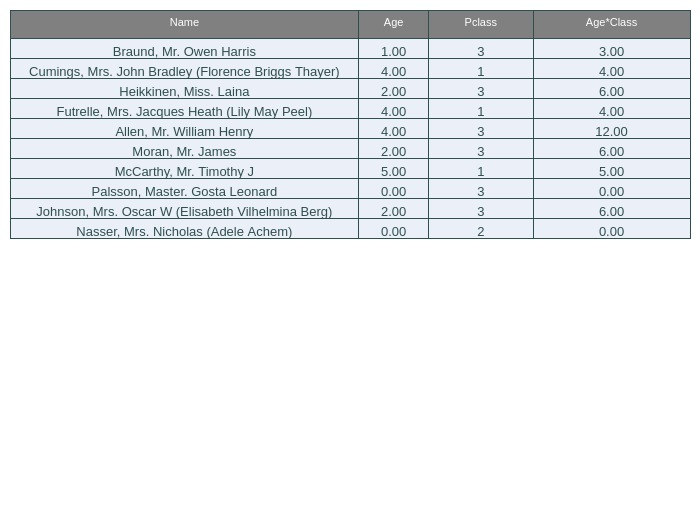

In [111]:
passenger_df.loc[:, ['Name', 'Age', 'Pclass', 'Age*Class']].vu(10,0)

## Feature Selection
In order to fit the "trained data", we turn the indexes in the combined dataset to whoever has a null in survived (meaning they're from the test dataset) into -1 value, therefore -1 is test and 0/1 is trained.

In [112]:
# Feature selection
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp','HasCabin',
                 'AgeEstimated', 'cDeck', 'cNum', 'cCheck', 'tPref',
                 'tNum', 'tCheck', 'tPrefTr', 'ClassDeck', 'lName',
                 'Title', 'fName', 'sName', 'SexClass', 'EmbClass',
                 'CategoricalAge', 'CategoricalFare']

passenger_df = passenger_df.drop(drop_elements, axis = 1, errors='ignore')
passenger_df = passenger_df.drop([], axis = 1, errors='ignore')

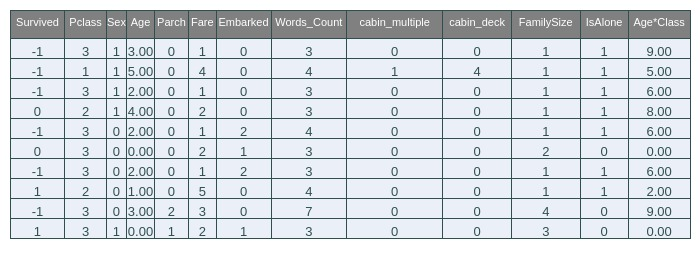

In [113]:
passenger_df.vu(10)

Splitting the dataset back into training and testing 

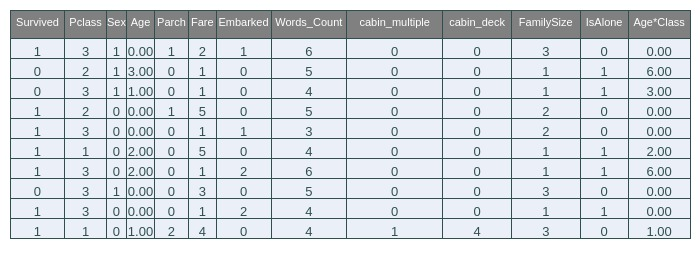

In [114]:
passenger_df_train = passenger_df[passenger_df.Survived != -1]
passenger_df_train.vu(10)

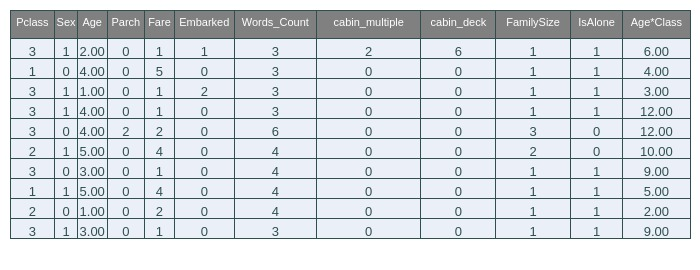

In [115]:
passenger_df_test = passenger_df[passenger_df.Survived == -1].drop("Survived", axis=1)
passenger_df_test.vu(10)

In [116]:
passenger_df_corr=passenger_df_train.astype(float).corr()

<Axes: title={'center': 'Pearson Correlation of Features'}>

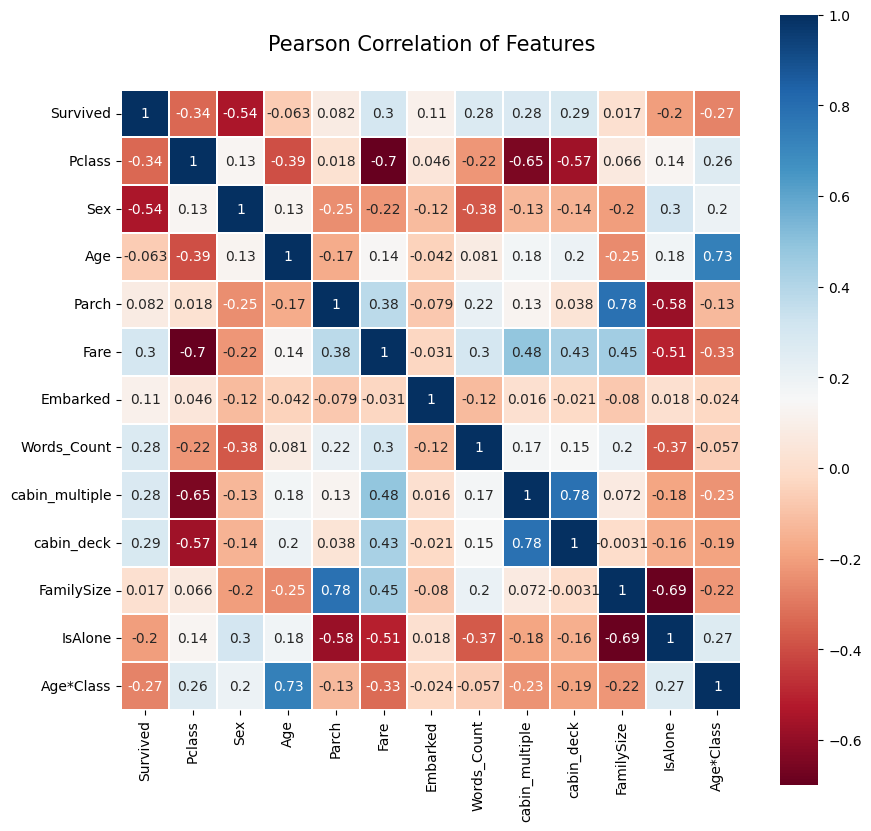

In [117]:
colormap=plt.cm.RdBu
fig = plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(passenger_df_corr,linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

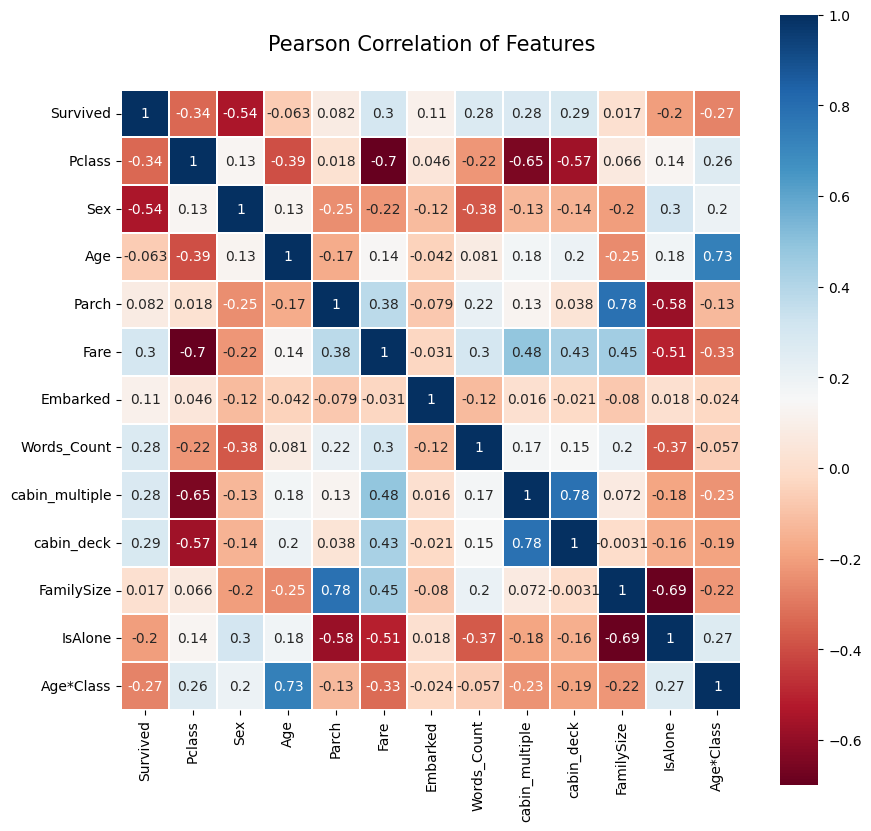

In [118]:
fig

## Takeaway from the Heatmap

There aren't many features strongly correlated with one another (highest is 0.78 between Parch and FamilySize and between the two cabin features. We'll still leave both features.) This is good from a point of view of feeding these features into your learning model because there isn't much redundant or superfluous data in our training set and we accept that each feature carries data with some unique information.

# Model Learning

## Splitting the passenger data 80/20
We split the data into training data and validation data randomly. so that 80 percent will be for training and 20 percent for validation the performance of the model and comparing the two models.
The splitting is done randomly so that 20 percent of samples are chosen randomly so that there is no connection between them so that the testing and comparison between the models are reliable.

In [119]:
X = passenger_df_train.drop('Survived', axis=1)
y = passenger_df_train['Survived']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Functions

### Train and Evaluate models

In [120]:
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings() #category=ConvergenceWarning)
def train_and_evaluate_models(models, X_train, y_train, X_val, y_val, 
                              param_grids, scoring='accuracy', cv=10):
    results = {}
    evaluation_data = []  # Create a list to store evaluation data

    for model_name, model in models.items():
        param_grid = param_grids[model_name]

        grid_search = model_selection.RandomizedSearchCV(n_iter=iterations,
                                                         estimator=model,
                                                         param_distributions=param_grid,
                                                         scoring=scoring, cv=cv)
        grid_search.fit(X_train, y_train)

        params = grid_search.cv_results_['params']
        scores = grid_search.cv_results_['mean_test_score']

        best_params = grid_search.best_params_
        best_score = grid_search.best_score_

        model.set_params(**best_params)
        model.fit(X_train, y_train)

        validation_score = model.score(X_val, y_val)

        results[model_name] = {
            'best_params': best_params,
            'best_score': best_score,
            'validation_score': validation_score
        }

        # Append evaluation data as a dictionary to the list
        evaluation_data.append({
            'Model': model_name,
            'Best Parameters': best_params,
            'Best Score (CV)': best_score,
            'Validation Score': validation_score
        })
        visualize_grid_search_results(param_grid, params, scores,
                                      best_params, best_score, model_name)
    # Create a DataFrame from the list of evaluation data
    evaluation_df = pd.DataFrame(evaluation_data)

    return results, evaluation_df

### Visualize Results

In [121]:
def visualize_grid_search_results(param_grid, params, scores, best_params, best_score,title=''):
    plt.figure(figsize=(18, 12))

    for i, param_name in enumerate(param_grid.keys()):
        plt.subplot(2, 2, i + 1)
        param_values = [param[param_name] for param in params]
        plt.plot(param_values, scores, marker='o')
        plt.xlabel(param_name)
        plt.ylabel('Mean Test Score')
        plt.title('Grid Search CV Results for {}{}'.format(param_name, ' - ' + title if title else ''))
        plt.grid(True)

      # Marking the best parameter value
        best_value = best_params[param_name]
        plt.scatter(best_value, best_score, color='red', label='Best: {} = {:.2f}'.format(param_name, best_value))
        plt.annotate('Best: {} = {:.2f}'.format(param_name, best_value), xy=(best_value, best_score), xytext=(best_value, best_score + 0.02),
                         arrowprops=dict(facecolor='black', arrowstyle='->'), horizontalalignment='center')
        plt.legend()

    plt.tight_layout()
    plt.show()

### Confusion Matrix for Best Model

In [122]:
def evaluate_best_model(best_model, X_train, y_train, X_val, y_val):
    train_predictions = best_model.predict(X_train)
    val_predictions = best_model.predict(X_val)

    train_accuracy = accuracy_score(y_train, train_predictions)
    val_accuracy = accuracy_score(y_val, val_predictions)

    # Confusion matrix 
    conf_matrix = confusion_matrix(y_val, val_predictions)

    # Calculate precision, recall, and F1-score for
    precision = precision_score(y_val, val_predictions)
    recall = recall_score(y_val, val_predictions)
    f1 = f1_score(y_val, val_predictions)

    # Plot confusion matrix with additional metrics
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title(f"Confusion Matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.text(0.5, 1.15, f"Precision: {precision:.2f}\nRecall: {recall:.2f}\nF1-score: {f1:.2f}",
             horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.tight_layout()
    plt.show()

    print("Train Accuracy: {:.4f}".format(train_accuracy))
    print("Validation Accuracy: {:.4f}".format(val_accuracy))

    return train_accuracy, val_accuracy, precision, recall, f1

## Classic models
Initialize models with Hyperparameters

In [123]:
# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Decision Tree': DecisionTreeClassifier()
}

# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Random Forest': {'n_estimators': [10, 50, 100, 200, 500], 
                      'max_depth': [None, 10, 20, 30, 50]},
    'SVM': {'C': [0.01, 0.1, 1, 10, 100], 'gamma': [0.01, 0.1, 1, 10, 100]},
    'Gradient Boosting': {'n_estimators': [10, 50, 100, 200, 500], 
                          'learning_rate': [0.001, 0.01, 0.1, 1]},
    'Decision Tree': {'max_depth': [None, 10, 20, 30, 50, 100]}
}

#### Training and Evaluating the models
Showing the process of Cross Validation using each and every combination of parameters for each model, so we can show in the final dataframe their best parameter combination (highest model mean test score)

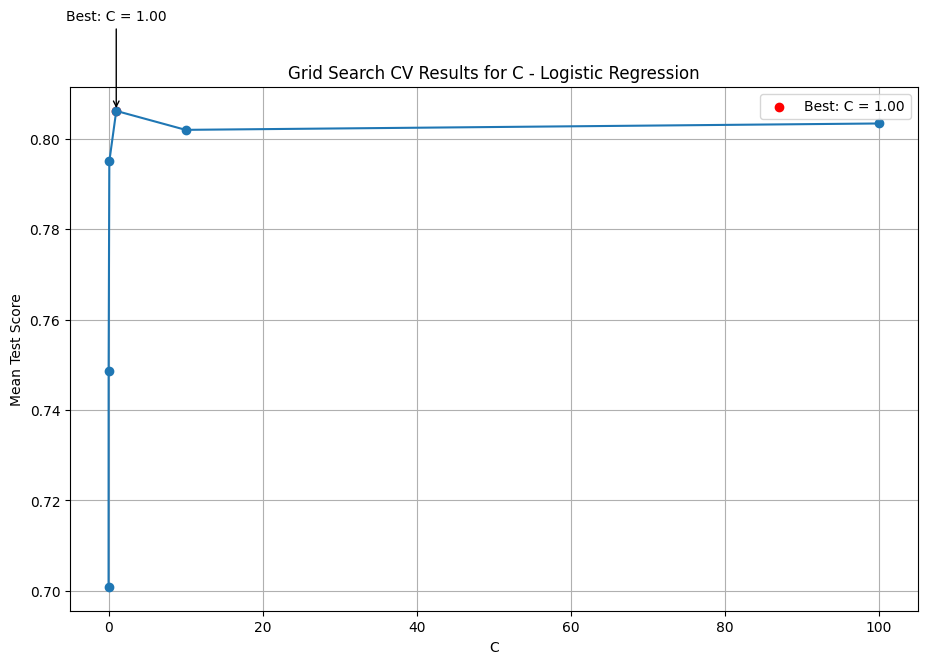

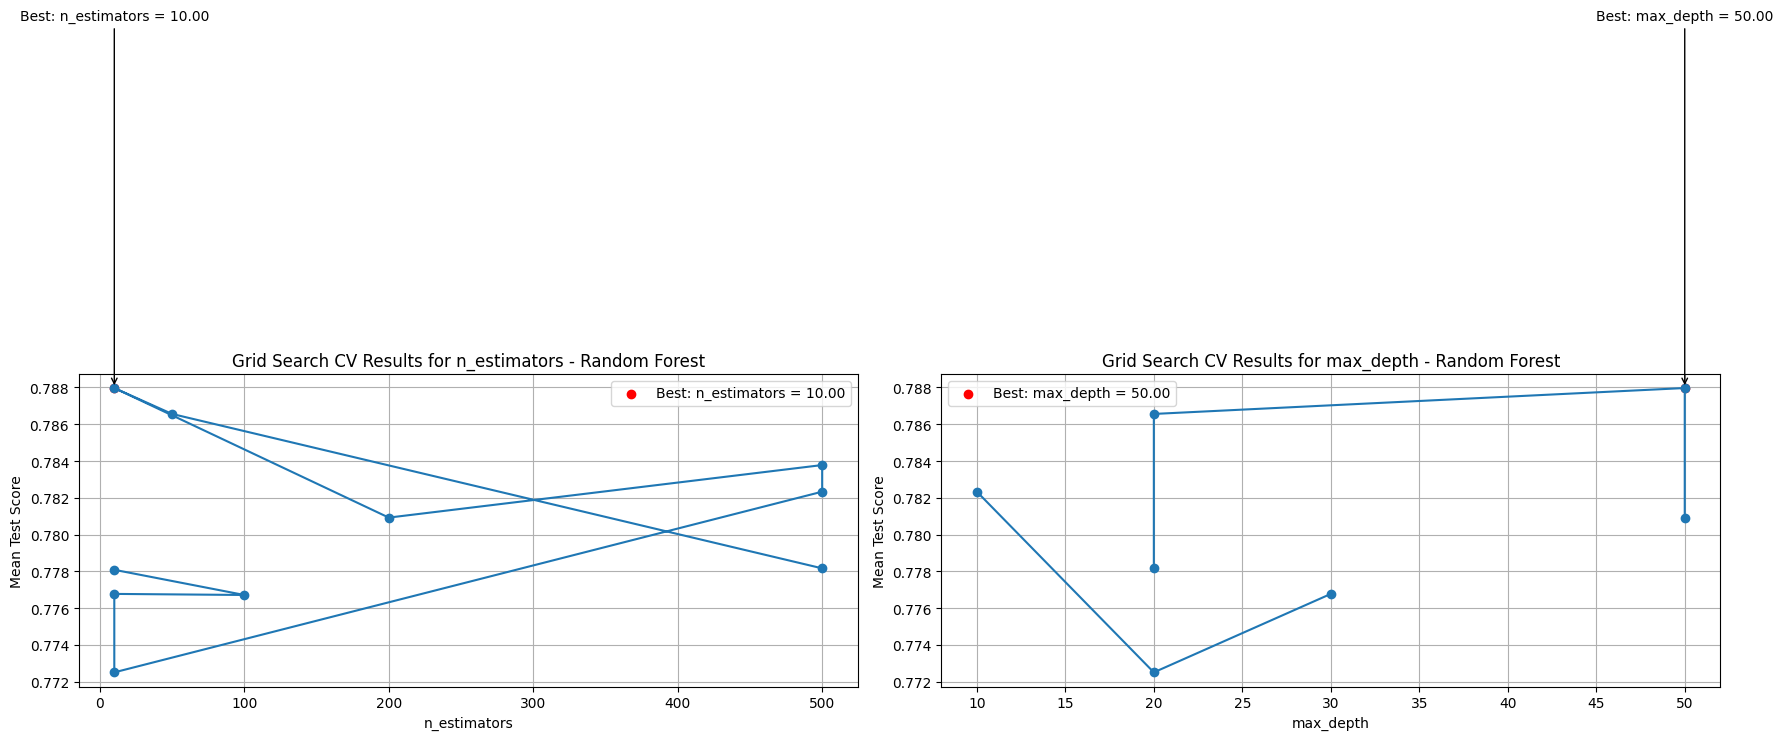

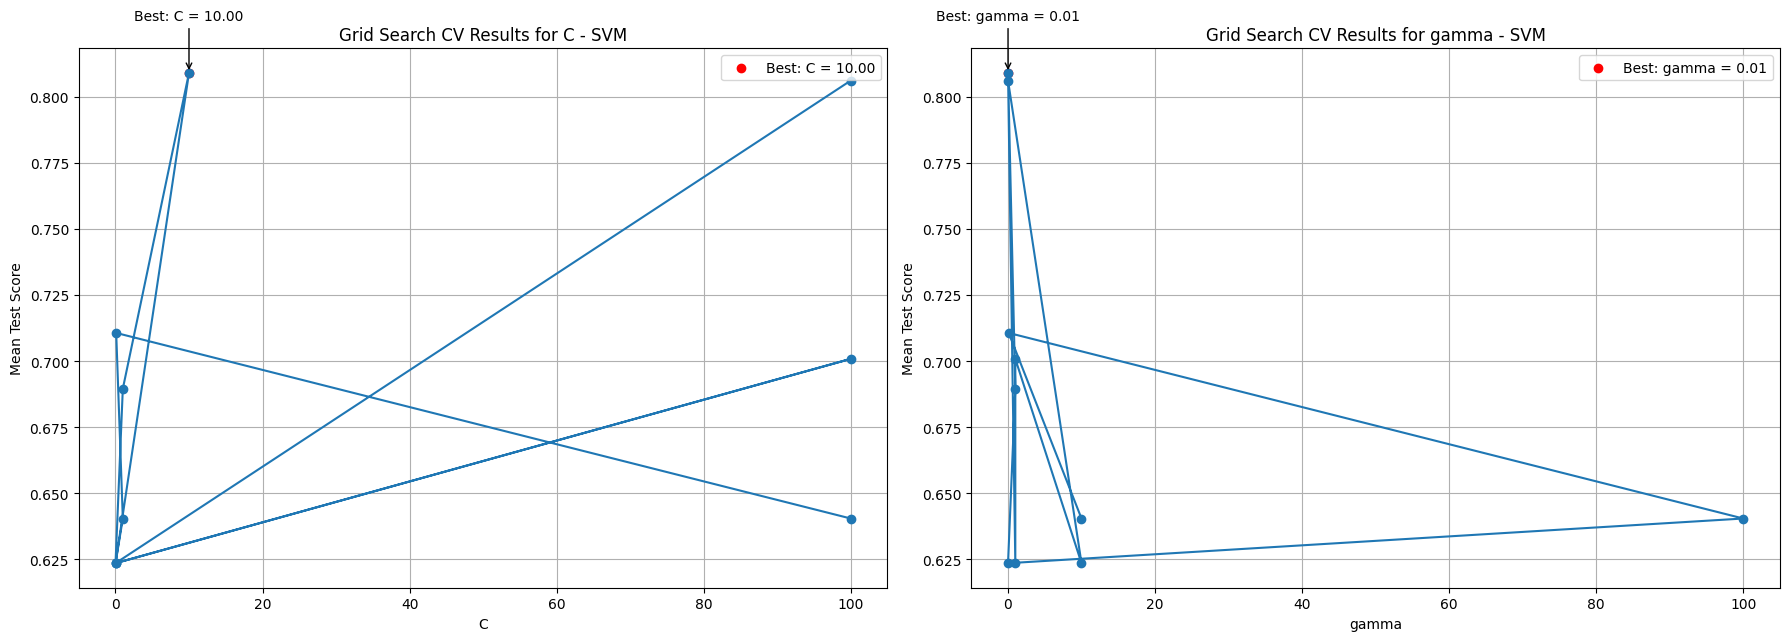

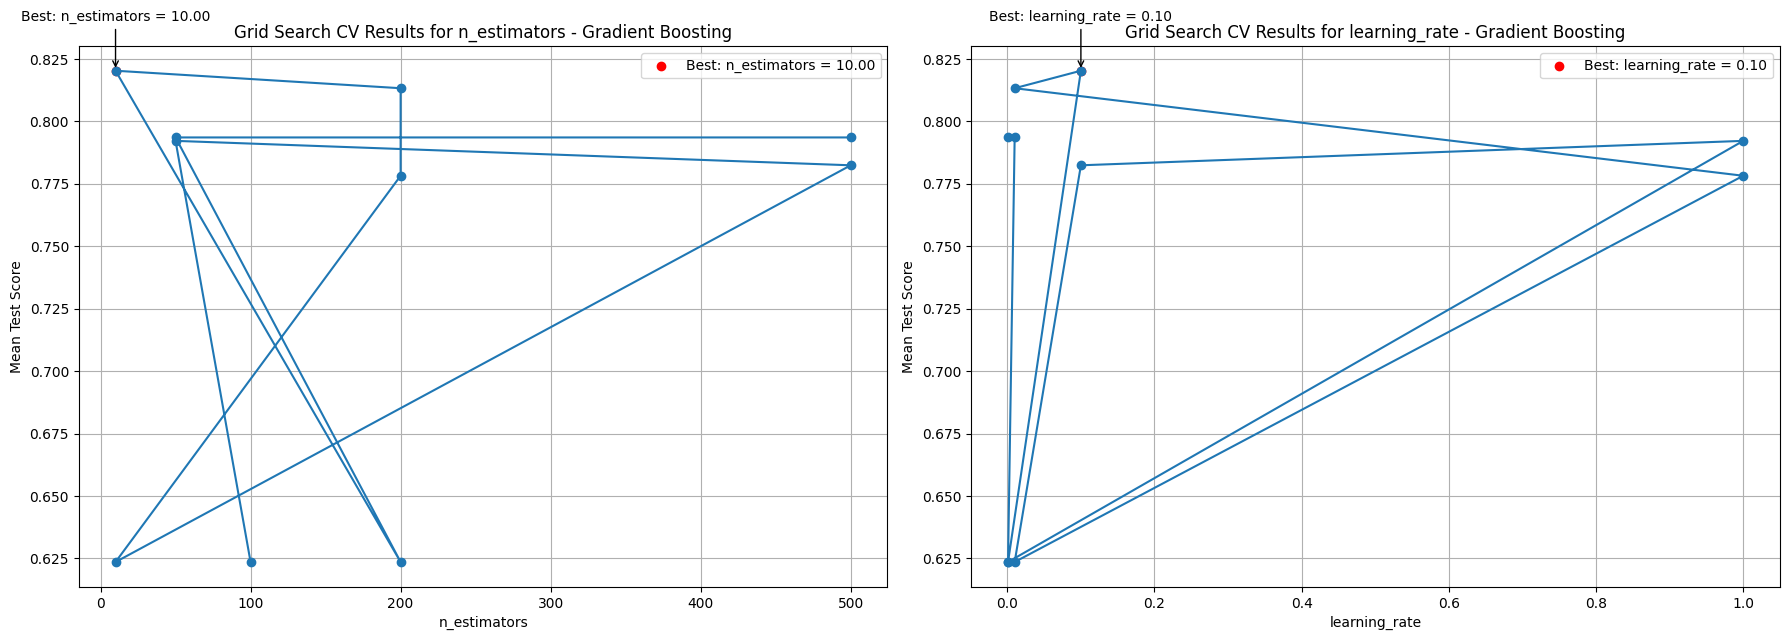

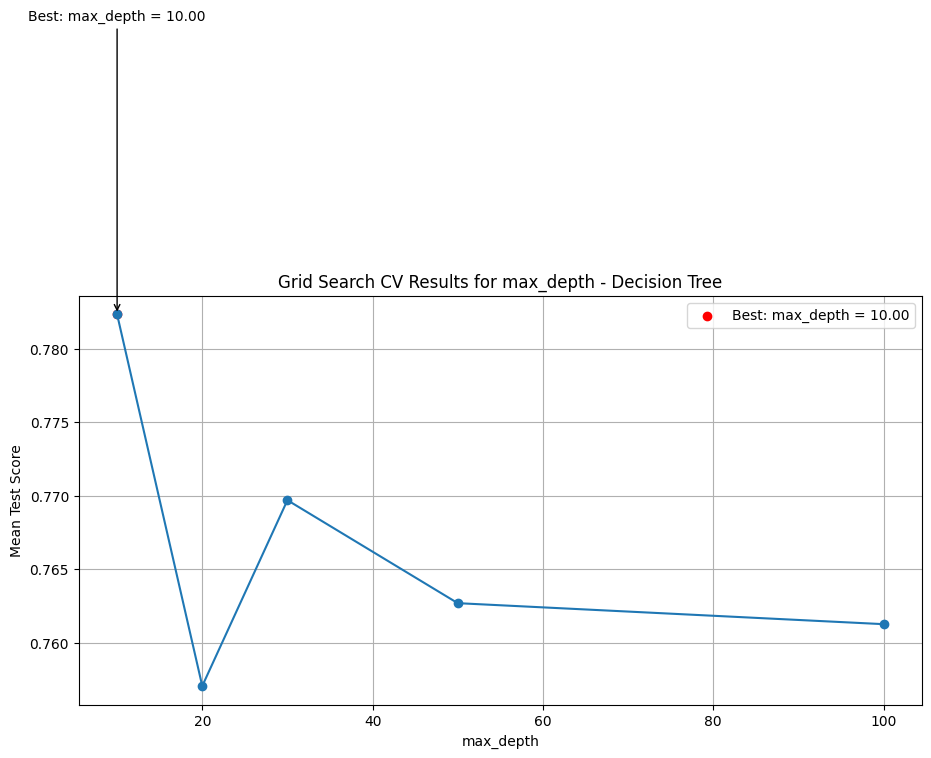

In [124]:
results, evaluation_df = train_and_evaluate_models(models, X_train, y_train, X_val, y_val, 
                                                   param_grids, scoring='accuracy', cv=10)

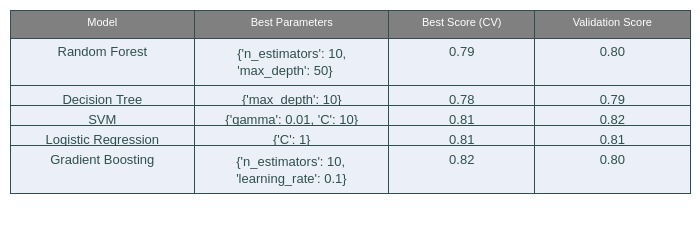

In [125]:
evaluation_df.vu(5)

We can see that Random Forest gives us the best Validation score, meaning Random Forest works best with new Data.

In [126]:
best_model_row = evaluation_df.loc[evaluation_df['Validation Score'].idxmax()]
best_model_name = best_model_row['Model']
best_validation_score = best_model_row['Validation Score']
best_model = models[best_model_name]

best = "Best Model: " + best_model_name
best+= f"\nBest Parameters: {best_model_row['Best Parameters']}"
best+= "\nBest Validation Score: {:.4f}" .format(best_validation_score)

In [127]:
print(best)

Best Model: SVM
Best Parameters: {'gamma': 0.01, 'C': 10}
Best Validation Score: 0.8156


In [128]:
chosen_model = "Random Forest" #"Gradient Boosting"
print(chosen_model, f"with {iterations} iterations")
if iterations > 500 and best_model_name != chosen_model:
    raise AssertionError("best model is not what we wanted! ")

Random Forest with 10 iterations


In [129]:
par = best_model.get_params()
par["Model"]= best_model_name
model_summary = pd.DataFrame.from_dict(par, orient="index", columns=["value"])
model_summary['Parameter'] = model_summary.index
model_summary = model_summary[['Parameter', "value"]]

Short summary of the best model:

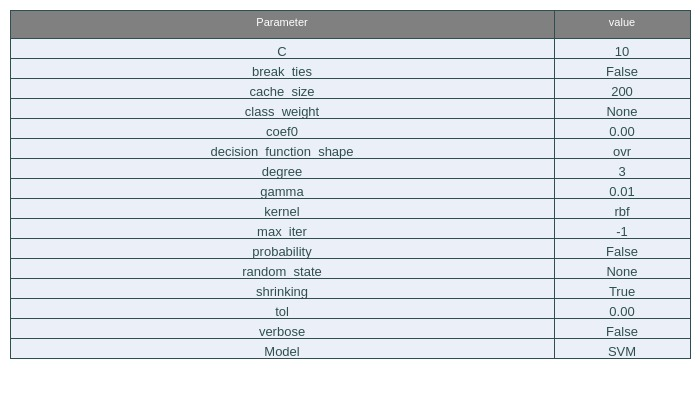

In [130]:
model_summary.vu(model_summary.shape[0], 0)

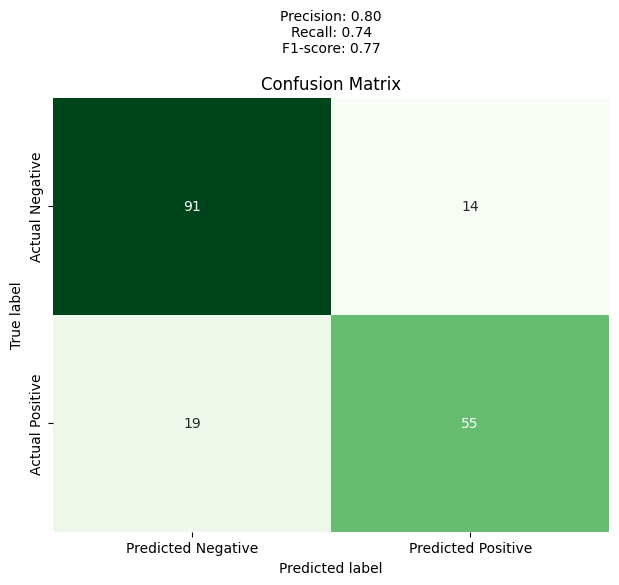

Train Accuracy: 0.8244
Validation Accuracy: 0.8156


In [131]:
sc = evaluate_best_model(best_model, X_train, y_train, X_val, y_val)

### Results
Final Model that was running on the validation data created:
- 83.24% Accuracy for Survival


*we added more variety of values in the parameters, but it took longer with no impact to the accuracy, so we stayed with these values.

# Test input data for submission

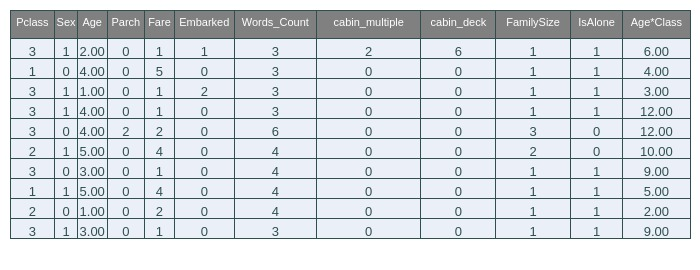

In [132]:
passenger_df_test = passenger_df[passenger_df.Survived == -1].drop("Survived", axis=1)
passenger_df_test.vu(10)

In [133]:
predictions = best_model.predict(passenger_df_test)
predictions = predictions.astype(int)
output = pd.DataFrame({'PassengerId': passenger_df_test.index, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


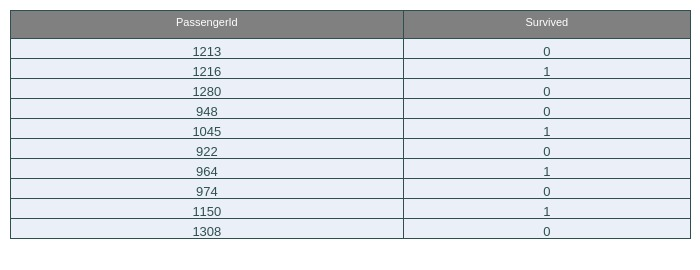

In [134]:
output.vu(10)

## Discussion
Our Hypothesis between each other was:
- Should we classify and engineer missing values in the data or just randomly write values based on the mean and standard deviation of the data?
- Based on the preprocessed data, which is the best model to learn new data?

The Hypothesis is answered in multiple categories:

### Preprocessing
Based on the Inferred data, some features that have barely any contribution to classifing Survival like Ticket, Name and even in some cases Cabin. Therefore we either need to completely filter them or engineer them to further correlate with the data. Important Features like Age, Family members and Sex need to fully encode for them to get learned by the model. Age specifically has some null values, therefore the easiest process to fill the missing values is to randomly assign values based on mean and standard deviation, but it's less accurate. We decided that the most accurate method to fill missing values in Age is to estimate based on learning the other features in the data and using regression models.

### Inference
This Step takes the prepocessed data from the previous step, and the objective is to classify if the passenger survives or not, therefore we need a classification model. we used 5 model types: Logistic Regression, Decision Trees, SVM, Random Forest and Gradient Boosting. Each with numerous parameter values added into a 10-fold Cross Validation function, which picks the combination that estimates the trained data with the highest accuracy score(Visualized in GridScores for each parameter). We considered using regularization models Lasso and Ridge to introduce cost functions fitting regression models and rounding up there output values ( submitted to Kaggle in addition to the actual notebook) and concluded that the main focus of this task is classification, therefore we put the regression models asside.


### Postprocessing
After model training different models, we pick the model based on its accuracy metrics with new data, in othe words, validation data that hasn't been trained in the models. We assumed the best model to fit the data is based on decision trees (Boosting,Random Forest or Regular Trees). After comparing model training, Random Forest gives the best validation accuracy score, therefore we'll use this model for estimating test data.

# Build PDFs

In [135]:
#! myst clean --cache --temp -y &  myst build --pdf --docx